# 1. Setup


In [1]:
!pip install opencv-python-headless
!pip install tqdm
!pip install pytorch-msssim lpips
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from tqdm import tqdm
import glob

# img processing
import cv2
from PIL import Image
import numpy as np

import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torchvision.transforms import Compose, Resize, ToTensor

# pckgs for results librarys
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import pandas as pd
import time
import matplotlib.pyplot as plt
import lpips
from pytorch_msssim import ssim

import os
from google.colab import drive
from google.colab import auth
import shutil
import math
import traceback


try:
    from pytorch_msssim import ssim as ssim_pytorch, ms_ssim
    from skimage.metrics import peak_signal_noise_ratio as psnr_metric_skimage
    from skimage.metrics import structural_similarity as ssim_metric_skimage
except ImportError as e:
    print(f"Error importing metric libraries: {e}")


from torch.optim.lr_scheduler import ReduceLROnPlateau


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# 2. Importing & Loading the Dataset

In [2]:

auth.authenticate_user()  #
drive.mount('/content/drive', force_remount=True)
os.makedirs("/content/ebb_dataset", exist_ok=True)


Mounted at /content/drive


In [3]:
!wget "http://data.vision.ee.ethz.ch/ihnatova/public/ebb/Bokeh_Simulation_Dataset.zip" -O ebb_dataset/EBB_dataset.zip
!unzip -oq ebb_dataset/EBB_dataset.zip -d ebb_dataset/
base_path = f'/content/ebb_dataset/'

--2025-05-05 20:24:33--  http://data.vision.ee.ethz.ch/ihnatova/public/ebb/Bokeh_Simulation_Dataset.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/ihnatova/public/ebb/Bokeh_Simulation_Dataset.zip [following]
--2025-05-05 20:24:34--  https://data.vision.ee.ethz.ch/ihnatova/public/ebb/Bokeh_Simulation_Dataset.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3791786922 (3.5G) [application/zip]
Saving to: ‘ebb_dataset/EBB_dataset.zip’

ebb_dataset/EBB_dat 100%[===================>]   3.53G  22.1MB/s    in 2m 45s  

2025-05-05 20:27:20 (21.9 MB/s) - ‘ebb_dataset/EBB_dataset.zip’ saved [3791786922/3791786922]



In [4]:
# fixed incorrect naming of test data as the validation set
!mv /content/ebb_dataset/validation /content/ebb_dataset/test
!echo "Renamed 'validation' directory to 'test'."
!ls /content/ebb_dataset/

Renamed 'validation' directory to 'test'.
EBB_dataset.zip  README.txt  test  train


In [5]:
# @title Perform validation split on original training data

BASE_PATH = '/content/ebb_dataset/'
ORIGINAL_TRAIN_FOLDER = os.path.join(BASE_PATH, 'train')
NEW_VALIDATION_FOLDER = os.path.join(BASE_PATH, 'validation') # new folder
VALIDATION_SPLIT_RATIO = 0.20
SPLIT_SEED = 42

print(f"Source Train Folder: {ORIGINAL_TRAIN_FOLDER}")
print(f"Target Validation Folder: {NEW_VALIDATION_FOLDER}")
print(f"Validation Split Ratio: {VALIDATION_SPLIT_RATIO:.0%}")

# checks below:
if not os.path.isdir(ORIGINAL_TRAIN_FOLDER):
    print(f"ERROR: Original training folder '{ORIGINAL_TRAIN_FOLDER}' not found. Cannot split.")
elif os.path.isdir(NEW_VALIDATION_FOLDER):
    print(f"ERROR: Target validation folder '{NEW_VALIDATION_FOLDER}' already exists.")
    print("       Please remove or rename it if you want to re-run the split.")
    print("       Skipping file moving operation.")
else:
    original_subdir = os.path.join(ORIGINAL_TRAIN_FOLDER, 'original')
    bokeh_subdir = os.path.join(ORIGINAL_TRAIN_FOLDER, 'bokeh')

    if not os.path.isdir(original_subdir) or not os.path.isdir(bokeh_subdir):
        print(f"ERROR: Missing 'original' or 'bokeh' subdirectories inside {ORIGINAL_TRAIN_FOLDER}.")
    else:
        print("Finding image pairs in original training folder...")
        try:
            original_files = set(f for f in os.listdir(original_subdir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG')))
            bokeh_files = set(f for f in os.listdir(bokeh_subdir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG')))
        except FileNotFoundError:
             print("Error listing files during pair finding.")
             original_files, bokeh_files = set(), set()

        image_pair_names = sorted(list(original_files.intersection(bokeh_files)))
        num_total_pairs = len(image_pair_names)

        if num_total_pairs == 0:
            print("ERROR: No matching image pairs found in the original training folder. Cannot split.")
        else:
            print(f"Found {num_total_pairs} image pairs.")

            # calc split sizes
            num_val_pairs = int(math.floor(VALIDATION_SPLIT_RATIO * num_total_pairs))
            num_train_pairs_new = num_total_pairs - num_val_pairs
            print(f"Calculated split: {num_train_pairs_new} pairs for new Train, {num_val_pairs} pairs for new Validation.")

            # shuffling and selecting
            np.random.seed(SPLIT_SEED)
            indices = list(range(num_total_pairs))
            np.random.shuffle(indices)
            validation_indices = indices[:num_val_pairs]
            validation_files_to_move = [image_pair_names[i] for i in validation_indices]
            print(f"Selected {len(validation_files_to_move)} files for validation set.")

            # new val directories
            new_val_original_dir = os.path.join(NEW_VALIDATION_FOLDER, 'original')
            new_val_bokeh_dir = os.path.join(NEW_VALIDATION_FOLDER, 'bokeh')
            try:
                os.makedirs(new_val_original_dir, exist_ok=True)
                os.makedirs(new_val_bokeh_dir, exist_ok=True)
                print(f"Created new validation directories:")
                print(f"  - {new_val_original_dir}")
                print(f"  - {new_val_bokeh_dir}")
            except OSError as e:
                print(f"ERROR creating validation directories: {e}")
                validation_files_to_move = [] # Prevent moving if dirs failed

            # move files
            if validation_files_to_move:
                print(f"\nMoving {len(validation_files_to_move)} pairs to validation folder...")
                moved_count = 0
                error_count = 0
                for filename in tqdm(validation_files_to_move, desc="Moving Files"):

                    src_orig_path = os.path.join(original_subdir, filename)
                    src_bokeh_path = os.path.join(bokeh_subdir, filename)

                    dst_orig_path = os.path.join(new_val_original_dir, filename)
                    dst_bokeh_path = os.path.join(new_val_bokeh_dir, filename)

                    try:
                        if os.path.exists(src_orig_path) and os.path.exists(src_bokeh_path):
                             shutil.move(src_orig_path, dst_orig_path)
                             shutil.move(src_bokeh_path, dst_bokeh_path)
                             moved_count += 1
                        else:
                             print(f"Warning: Source file missing, cannot move {filename}")
                             error_count += 1
                    except Exception as e:
                        print(f"ERROR moving file {filename}: {e}")
                        error_count += 1

                print(f"\nFile Moving Complete:")
                print(f"  Successfully moved {moved_count} pairs.")
                if error_count > 0:
                    print(f"  Encountered errors for {error_count} pairs.")

                # final checkss
                print("\nVerifying final counts...")
                final_train_orig_count = len([f for f in os.listdir(original_subdir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG'))])
                final_val_orig_count = len([f for f in os.listdir(new_val_original_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG'))])
                print(f"  Files remaining in '{original_subdir}': {final_train_orig_count} (Expected: {num_train_pairs_new})")
                print(f"  Files moved to '{new_val_original_dir}': {final_val_orig_count} (Expected: {num_val_pairs})")
            else:
                 print("No files selected for moving (possibly due to directory creation error).")



Source Train Folder: /content/ebb_dataset/train
Target Validation Folder: /content/ebb_dataset/validation
Validation Split Ratio: 20%
Finding image pairs in original training folder...
Found 4694 image pairs.
Calculated split: 3756 pairs for new Train, 938 pairs for new Validation.
Selected 938 files for validation set.
Created new validation directories:
  - /content/ebb_dataset/validation/original
  - /content/ebb_dataset/validation/bokeh

Moving 938 pairs to validation folder...


Moving Files: 100%|██████████| 938/938 [00:00<00:00, 10305.09it/s]


File Moving Complete:
  Successfully moved 938 pairs.

Verifying final counts...
  Files remaining in '/content/ebb_dataset/train/original': 3756 (Expected: 3756)
  Files moved to '/content/ebb_dataset/validation/original': 938 (Expected: 938)


# 3. Models

In [6]:
class BokehDataset(Dataset):
    def __init__(self, original_dir, bokeh_dir, transform=None):
        self.original_dir = original_dir
        self.bokeh_dir = bokeh_dir
        self.image_names = sorted(os.listdir(original_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        original_path = os.path.join(self.original_dir, self.image_names[idx])
        bokeh_path = os.path.join(self.bokeh_dir, self.image_names[idx])

        original_image = Image.open(original_path).convert('RGB')
        bokeh_image = Image.open(bokeh_path).convert('RGB')

        if self.transform:
            original_image = self.transform(original_image)
            bokeh_image = self.transform(bokeh_image)

        return original_image, bokeh_image


In [7]:
# CNN 3 level construction
class bokeh_CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(bokeh_CNN, self).__init__()
        features = init_features
        # Input channels used here
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False), # use in_channels
            nn.BatchNorm2d(features), nn.ReLU(True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features), nn.ReLU(True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        # Encoder lvl2
        self.enc2 = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features * 2), nn.ReLU(True),
            nn.Conv2d(features * 2, features * 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features * 2), nn.ReLU(True)
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        # Encoder LVL 3
        self.enc3 = nn.Sequential(
            nn.Conv2d(features * 2, features * 4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features * 4), nn.ReLU(True),
            nn.Conv2d(features * 4, features * 4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features * 4), nn.ReLU(True)
        )
        # Decoder levl 2
        self.up2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            # Input channels = upsampled channels + skip connection channels
            nn.Conv2d(features * 4, features * 2, kernel_size=3, padding=1, bias=False), # features*2 (from up2) + features*2 (from enc2)
            nn.BatchNorm2d(features * 2), nn.ReLU(True),
            nn.Conv2d(features * 2, features * 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features * 2), nn.ReLU(True)
        )
        # Decoder level 1
        self.up1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            # input channels = upsampled channels + skip connection channels
            nn.Conv2d(features * 2, features, kernel_size=3, padding=1, bias=False), # features (from up1) + features (from enc1)
            nn.BatchNorm2d(features), nn.ReLU(True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features), nn.ReLU(True)
        )
        # final output conv
        self.output_conv = nn.Conv2d(features, out_channels, kernel_size=1) # bias is okay in final layer

    def forward(self, x):
        # enc path
        x1 = self.enc1(x)
        p1 = self.pool1(x1)
        x2 = self.enc2(p1)
        p2 = self.pool2(x2)
        x3 = self.enc3(p2) # Bottleneck

        # Decoder path with skip connections
        u2 = self.up2(x3)
        # handle pot. size mismatches (less likely though as using padding=1 and stride=2)
        diffY = x2.size()[2] - u2.size()[2]
        diffX = x2.size()[3] - u2.size()[3]
        u2 = F.pad(u2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        cat2 = torch.cat([u2, x2], dim=1) # concatenate along channel dimension
        x4 = self.dec2(cat2)

        u1 = self.up1(x4)
        diffY = x1.size()[2] - u1.size()[2]
        diffX = x1.size()[3] - u1.size()[3]
        u1 = F.pad(u1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        cat1 = torch.cat([u1, x1], dim=1)
        x5 = self.dec1(cat1)

        out = self.output_conv(x5)

        return torch.sigmoid(out)



model_instance = bokeh_CNN(in_channels=4, out_channels=3, init_features=32)

total_params = sum(p.numel() for p in model_instance.parameters())

trainable_params = sum(p.numel() for p in model_instance.parameters() if p.requires_grad)

print(f"Input Channels: {model_instance.enc1[0].in_channels}")
print(f"Output Channels: {model_instance.output_conv.out_channels}")
print(f"Initial Features: {model_instance.enc1[0].out_channels}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("-----------------------------------------------------\n")

Input Channels: 4
Output Channels: 3
Initial Features: 32
Total parameters: 467,523
Trainable parameters: 467,523
-----------------------------------------------------



# 4. Multi weighted Loss function - inspired by PyNet except all combined

In [8]:
def gaussian_pyramid(img: torch.Tensor, max_levels: int = 3) -> list:
    # separable 5-tap Gaussian kernel
    k1d = torch.tensor([1.,4.,6.,4.,1.], device=img.device) / 16.
    ker = (k1d[:,None] * k1d[None,:]).unsqueeze(0).unsqueeze(0)
    ker = ker.repeat(img.size(1),1,1,1)
    pyr = [img]
    cur = img
    for _ in range(max_levels):
        blurred = F.conv2d(cur, ker, padding=2, groups=cur.size(1))
        cur = blurred[:, :, ::2, ::2]
        pyr.append(cur)
    return pyr

class WeightedPyNetPerceptualLoss(nn.Module):
    def __init__(self,
                 fg_weight: float = 2.0,
                 bg_weight: float = 1.0,
                 max_levels: int = 3,
                 level_weights: list = None,
                 lpips_weight: float = 1.0,
                 ssim_weight: float = 1.0):
        super().__init__()
        self.fg_w, self.bg_w = fg_weight, bg_weight
        self.max_levels = max_levels
        self.level_weights = level_weights or [1.0/(2**i) for i in range(max_levels+1)]
        self.lpips_fn = lpips.LPIPS(net='alex').eval()
        self.lpips_weight = lpips_weight
        self.ssim_weight  = ssim_weight

        # laplacian kernel for focus mask
        lap = torch.tensor([[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]])
        self.register_buffer('lap_kernel', lap.unsqueeze(0).unsqueeze(0))

    def generate_focus_mask(self, img: torch.Tensor, threshold: float = 0.03) -> torch.Tensor:
        gray = img.mean(dim=1, keepdim=True)
        lap  = F.conv2d(gray, self.lap_kernel, padding=1)
        return (lap.abs() > threshold).float()

    def forward(self,
                pred: torch.Tensor,
                target: torch.Tensor,
                original: torch.Tensor) -> (torch.Tensor, dict):
        mask_full = self.generate_focus_mask(original).to(pred.device)
        pred_pyr = gaussian_pyramid(pred, self.max_levels)
        tgt_pyr  = gaussian_pyramid(target, self.max_levels)

        l1_loss, ssim_loss = 0.0, 0.0
        for lvl, (p, t) in enumerate(zip(pred_pyr, tgt_pyr)):
            w_lvl = self.level_weights[lvl]
            mask_lvl = F.interpolate(mask_full, size=p.shape[2:], mode='nearest')
            pixel_w = mask_lvl * self.fg_w + (1 - mask_lvl) * self.bg_w

            l1 = (p - t).abs()
            l1_loss  += w_lvl * (l1 * pixel_w).mean()

            ssim_val = ssim(p, t, data_range=1.0)
            avg_w = pixel_w.mean()
            ssim_loss += w_lvl * (1 - ssim_val) * avg_w

        lpips_loss = self.lpips_fn(pred, target).mean()
        total = l1_loss + self.ssim_weight * ssim_loss + self.lpips_weight * lpips_loss

        return total, {
            'l1_multi':   l1_loss,
            'ssim_multi': ssim_loss,
            'lpips':      lpips_loss
        }

# 5. Mini training loops to evaluate different architectures and hyperparameter combinations (before final loop)

In [ ]:
# @title Vanilla U-Net experimentation, tweak hyperparameters for Table 1 & 2 Results

torch.manual_seed(42) # for reproducibility
np.random.seed(42)

# paths
BASE_PATH = '/content/ebb_dataset/'
DRIVE_SAVE_DIR = "/content/drive/MyDrive/Bokeh_MiniLoop_Runs"

# Mini-Loop DATA SUBSETS - for speed and due to compute constraints
TRAIN_SUBSET_TARGET_SIZE = 1024
VAL_SUBSET_TARGET_SIZE = 180


IMG_SIZE = 512
EVAL_CROP_BORDER = 32
EVAL_SSIM_WIN_SIZE = 11
GRAD_CLIP_VALUE = 1.0

os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)
print(f"Mini-loop models/checkpoints will be saved in: {DRIVE_SAVE_DIR}")

#setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running on device: {device} ---")

# Single Transform, no augm.
transform_no_aug = Compose([Resize((IMG_SIZE, IMG_SIZE)), ToTensor()])
print("Defined unified transform (No Augmentation).")

# dataset & loaders
train_loader_mini = None; val_loader_mini = None; test_loader = None
try:
    if 'BASE_PATH' not in globals() or not os.path.isdir(BASE_PATH): raise ValueError("'BASE_PATH' not defined")
    original_train_dir=os.path.join(BASE_PATH, 'train/original'); bokeh_train_dir=os.path.join(BASE_PATH, 'train/bokeh'); new_val_original_dir=os.path.join(BASE_PATH, 'validation/original'); new_val_bokeh_dir=os.path.join(BASE_PATH, 'validation/bokeh'); test_original_dir=os.path.join(BASE_PATH, 'test/original'); test_bokeh_dir=os.path.join(BASE_PATH, 'test/bokeh')
    print("Loading full original training dataset index for splitting..."); full_new_train_dataset = BokehDataset(original_dir=original_train_dir, bokeh_dir=bokeh_train_dir, transform=transform_no_aug); num_actual_train_samples = len(full_new_train_dataset); print(f"Found {num_actual_train_samples} pairs in 'train'."); assert num_actual_train_samples > 0
    print("Loading index for the new 'validation' dataset..."); full_new_val_dataset = BokehDataset(original_dir=new_val_original_dir, bokeh_dir=new_val_bokeh_dir, transform=transform_no_aug); num_actual_val_samples = len(full_new_val_dataset); print(f"Found {num_actual_val_samples} pairs in 'validation'."); assert num_actual_val_samples > 0
    train_subset_size = min(TRAIN_SUBSET_TARGET_SIZE, num_actual_train_samples); val_subset_size = min(VAL_SUBSET_TARGET_SIZE, num_actual_val_samples)
    train_subset_loop, _ = random_split(full_new_train_dataset, [train_subset_size, num_actual_train_samples - train_subset_size], generator=torch.Generator().manual_seed(42))
    val_subset_loop, _ = random_split(full_new_val_dataset, [val_subset_size, num_actual_val_samples - val_subset_size], generator=torch.Generator().manual_seed(42))
    print(f"\nMini-loop random subsets created: {len(train_subset_loop)} train / {len(val_subset_loop)} validation.")
    def collate_fn_skip_none(batch): batch=list(filter(lambda x: x is not None and x[0] is not None and x[1] is not None, batch)); return torch.utils.data.dataloader.default_collate(batch) if batch else None
    num_workers = 2 # BATCH_SIZE set in EXP block
    # Loaders configured in EXP block
    if os.path.isdir(test_original_dir) and os.path.isdir(test_bokeh_dir):
        test_dataset = BokehDataset(original_dir=test_original_dir, bokeh_dir=test_bokeh_dir, transform=transform_no_aug)
        if len(test_dataset) > 0: print(f"Test dataset loaded ({len(test_dataset)} samples).")
        else: print("Test dataset directory found but is empty.")
    else: print("Test dataset directory not found.")
except Exception as e: print(f"Error setting up Datasets/DataLoaders: {e}"); raise


# evaluation function definition ->
def evaluate_model(model, dataloader, lpips_eval_fn, crop_border=0, ssim_win_size=11):
    model.eval(); eval_device = next(model.parameters()).device; total_psnr, total_ssim_sk, total_msssim, total_lpips = 0.0, 0.0, 0.0, 0.0; lpips_msssim_count, psnr_ssim_count = 0, 0
    if dataloader is None: return 0,0,0,0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False, disable=len(dataloader)<5):
            if batch is None: continue
            try: inputs, targets = batch; assert isinstance(inputs, torch.Tensor) and isinstance(targets, torch.Tensor)
            except (AssertionError, TypeError, ValueError): continue
            if inputs.shape[1] != 3 or targets.shape[1] != 3: continue
            inputs, targets = inputs.to(eval_device), targets.to(eval_device); outputs = model(inputs)
            outputs_clipped = torch.clamp(outputs, 0.0, 1.0); current_batch_size = outputs_clipped.shape[0]; outputs_lpips_input = outputs_clipped * 2.0 - 1.0; targets_lpips_input = targets * 2.0 - 1.0
            try: lpips_val = lpips_eval_fn(outputs_lpips_input, targets_lpips_input.detach()); total_lpips += lpips_val.sum().item(); lpips_msssim_count += current_batch_size
            except Exception: pass
            try: ms_ssim_val_batch = ms_ssim(outputs_clipped, targets.detach(), data_range=1.0, size_average=False); total_msssim += ms_ssim_val_batch.sum().item()
            except Exception: pass
            outputs_np_full = outputs_clipped.cpu().numpy(); targets_np_full = targets.cpu().numpy()
            for i in range(current_batch_size):
                out_img_full_np = np.transpose(outputs_np_full[i], (1, 2, 0)); tgt_img_full_np = np.transpose(targets_np_full[i], (1, 2, 0)); h, w = out_img_full_np.shape[:2]
                if crop_border > 0 and h > 2 * crop_border and w > 2 * crop_border: out_img_eval_np=out_img_full_np[crop_border:-crop_border, crop_border:-crop_border, :]; tgt_img_eval_np=tgt_img_full_np[crop_border:-crop_border, crop_border:-crop_border, :]
                else: out_img_eval_np=out_img_full_np; tgt_img_eval_np=tgt_img_full_np
                try:
                    psnr=psnr_metric_skimage(tgt_img_eval_np, out_img_eval_np, data_range=1.0); ch_sk, cw_sk = tgt_img_eval_np.shape[:2]; current_win_size=min(ssim_win_size, ch_sk, cw_sk)
                    if current_win_size % 2 == 0: current_win_size -= 1; current_win_size=max(3, current_win_size)
                    if ch_sk >= current_win_size and cw_sk >= current_win_size : ssim_val_sk=ssim_metric_skimage(tgt_img_eval_np, out_img_eval_np, channel_axis=-1, data_range=1.0, win_size=current_win_size, gaussian_weights=True, multichannel=True)
                    else: ssim_val_sk = np.nan
                    if not np.isnan(psnr) and not np.isnan(ssim_val_sk): total_psnr+=psnr; total_ssim_sk+=ssim_val_sk; psnr_ssim_count+=1
                except ValueError: pass
    avg_psnr=total_psnr/psnr_ssim_count if psnr_ssim_count>0 else 0; avg_ssim_sk=total_ssim_sk/psnr_ssim_count if psnr_ssim_count > 0 else 0; avg_msssim=total_msssim/lpips_msssim_count if lpips_msssim_count > 0 else 0; avg_lpips=total_lpips/lpips_msssim_count if lpips_msssim_count > 0 else 0
    return avg_psnr, avg_ssim_sk, avg_msssim, avg_lpips

# training loop function
def run_mini_training_experiment(model_name, model, train_loader, val_loader, criterion, lpips_eval_fn, optimizer, epochs, device):

    print(f"--- Starting Mini-Loop Training: {model_name} ---"); model.to(device)
    history = {'train_loss':[], 'val_loss':[], 'val_l1_loss':[], 'val_psnr':[], 'val_ssim_sk':[], 'val_msssim':[], 'val_lpips':[]}
    start_run_time = time.time()
    if train_loader is None or len(train_loader)==0: print("ERROR: Train loader empty."); return history, *([float('nan')]*7), 0.0
    for epoch in range(epochs):
        epoch_start_time = time.time(); model.train(); running_train_loss = 0.0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} [MiniTrain]", leave=False)
        for i, batch in pbar:
            if batch is None: continue
            try: inputs, targets = batch; assert isinstance(inputs, torch.Tensor) and isinstance(targets, torch.Tensor)
            except (AssertionError, TypeError, ValueError): continue
            if inputs.shape[1] != 3 or targets.shape[1] != 3: continue
            try:
                inputs, targets = inputs.to(device), targets.to(device); optimizer.zero_grad(); outputs = model(inputs); total_loss, _ = criterion(pred=outputs, target=targets, original=inputs)
                if torch.isnan(total_loss) or torch.isinf(total_loss): continue
                total_loss.backward();
                if 'GRAD_CLIP_VALUE' in globals() and GRAD_CLIP_VALUE: torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                optimizer.step(); running_train_loss += total_loss.item(); pbar.set_postfix({'Loss': f'{total_loss.item():.4f}'})
            except Exception as batch_err: print(f"Error processing train batch {i}: {batch_err}"); traceback.print_exc(); continue
        avg_train_loss = running_train_loss / len(train_loader) if len(train_loader) > 0 else 0; history['train_loss'].append(avg_train_loss)
        model.eval(); running_val_loss = 0.0; running_val_l1_loss = 0.0; avg_val_l1_loss = float('nan'); avg_psnr, avg_ssim_sk, avg_msssim, avg_lpips = 0,0,0,0
        if val_loader is None or len(val_loader) == 0: print("Warning: Val loader empty."); avg_val_loss = float('nan')
        else:
            avg_psnr, avg_ssim_sk, avg_msssim, avg_lpips = evaluate_model(model, val_loader, lpips_eval_fn, EVAL_CROP_BORDER, EVAL_SSIM_WIN_SIZE)
            with torch.no_grad():
                for batch_val in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]", leave=False): # Add tqdm
                    if batch_val is None: continue
                    try: inputs_val, targets_val = batch_val; assert isinstance(inputs_val, torch.Tensor) and isinstance(targets_val, torch.Tensor)
                    except (AssertionError, TypeError, ValueError): continue
                    if inputs_val.shape[1] != 3 or targets_val.shape[1] != 3: continue
                    try:
                        inputs_val, targets_val = inputs_val.to(device), targets_val.to(device); outputs_val = model(inputs_val)
                        val_total_loss, val_loss_components = criterion(pred=outputs_val, target=targets_val, original=inputs_val)
                        if torch.isnan(val_total_loss) or torch.isinf(val_total_loss): continue
                        running_val_loss += val_total_loss.item(); running_val_l1_loss += val_loss_components.get('l1_multi_weighted', 0.0)
                    except Exception as val_batch_err: print(f"Error processing validation batch: {val_batch_err}"); continue
            avg_val_loss = running_val_loss / len(val_loader) if len(val_loader) > 0 else float('inf'); avg_val_l1_loss = running_val_l1_loss / len(val_loader) if len(val_loader) > 0 else float('nan')
        history['val_loss'].append(avg_val_loss); history['val_l1_loss'].append(avg_val_l1_loss); history['val_psnr'].append(avg_psnr); history['val_ssim_sk'].append(avg_ssim_sk); history['val_msssim'].append(avg_msssim); history['val_lpips'].append(avg_lpips)
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val L1: {avg_val_l1_loss:.4f} | PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim_sk:.4f}, MS-SSIM: {avg_msssim:.4f}, LPIPS: {avg_lpips:.4f} - Time: {epoch_duration:.2f}s")
    run_duration_mins = (time.time() - start_run_time) / 60.0; print(f"--- Finished Mini-Loop Training: {model_name} ({run_duration_mins:.2f} mins) ---")
    final_train_loss = history['train_loss'][-1] if history.get('train_loss') else float('nan'); final_val_loss = history['val_loss'][-1] if history.get('val_loss') else float('nan'); final_l1_loss = history['val_l1_loss'][-1] if history.get('val_l1_loss') else float('nan'); final_psnr = history['val_psnr'][-1] if history.get('val_psnr') else float('nan'); final_ssim_sk = history['val_ssim_sk'][-1] if history.get('val_ssim_sk') else float('nan'); final_msssim = history['val_msssim'][-1] if history.get('val_msssim') else float('nan'); final_lpips = history['val_lpips'][-1] if history.get('val_lpips') else float('nan')
    return history, final_train_loss, final_val_loss, final_l1_loss, final_psnr, final_ssim_sk, final_msssim, final_lpips, run_duration_mins



# --- MAIN MINI-LOOP EXPERIMENT EXECUTION BLOCK ---

EXP_ID = "Mini_VUNet_IF32_LW_S4.0_P0.5_B4_E10" # NEW ID
EXP_SSIM_WEIGHT = 4.0
EXP_LPIPS_WEIGHT = 0.5
EXP_BATCH_SIZE = 4
EXP_NUM_EPOCHS = 10
EXP_LEARNING_RATE = 2e-4


EXP_MODEL_CLASS = bokeh_CNN
EXP_MODEL_NAME = "Vanilla_UNet (bokeh_CNN)"
EXP_INIT_FEATURES = 32
EXP_INPUT_CHANNELS = 3
EXP_DEPTH_LEVELS = 3
MODEL_KWARGS = {}

# ---

print(f"\n\n{'='*30} STARTING MINI-LOOP EXPERIMENT: {EXP_ID} {'='*30}")

# instantiate
print(f"Instantiating model: {EXP_MODEL_NAME}..."); model_instance = None; params_m = float('nan')
try:
    # N.B. with BatchNorm
    model_instance = EXP_MODEL_CLASS(
        in_channels=EXP_INPUT_CHANNELS,
        out_channels=3,
        init_features=EXP_INIT_FEATURES,
        **MODEL_KWARGS
    ).to(device)
    total_params = sum(p.numel() for p in model_instance.parameters()); params_m = total_params / 1_000_000
    print(f"Model Instantiated: {params_m:.2f}M parameters")
except Exception as e: print(f"Model Instantiation Error: {e}"); raise

# config MINI DataLoaders
current_train_loader = None; current_val_loader = None
try:
    if 'train_subset_loop' not in globals() or 'val_subset_loop' not in globals(): raise NameError("Mini-loop subset datasets not defined.")
    current_train_loader = DataLoader(train_subset_loop, batch_size=EXP_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_skip_none)
    current_val_loader = DataLoader(val_subset_loop, batch_size=EXP_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_skip_none)
    print(f"Mini-loop DataLoaders configured with Batch Size: {EXP_BATCH_SIZE}"); assert len(current_train_loader)>0 and len(current_val_loader)>0
except Exception as e: print(f"Error configuring Mini-loop DataLoaders: {e}"); raise

# loss func.
criterion = None; lpips_eval_fn = None
try:
    criterion = WeightedPyNetPerceptualLoss(lpips_weight=EXP_LPIPS_WEIGHT, ssim_weight=EXP_SSIM_WEIGHT).to(device)
    lpips_eval_fn = lpips.LPIPS(net='alex', verbose=False).to(device)
    print(f"Loss function instantiated with SSIM_w={EXP_SSIM_WEIGHT}, LPIPS_w={EXP_LPIPS_WEIGHT}")
except Exception as e: print(f"Loss Instantiation Error: {e}"); raise


print("\n--- Mini-Loop Experiment Configuration ---"); print(f"Exp ID:          {EXP_ID}"); print(f"Model Arch:      {EXP_MODEL_NAME}"); print(f"Input Channels:  {EXP_INPUT_CHANNELS} (RGB)"); print(f"Width (IF):      {EXP_INIT_FEATURES}"); print(f"Depth (Levels):  {EXP_DEPTH_LEVELS}"); print(f"Learning Rate:   {EXP_LEARNING_RATE}"); print(f"Batch Size:      {EXP_BATCH_SIZE}"); print(f"Target Epochs:   {EXP_NUM_EPOCHS}"); print(f"SSIM Weight:     {EXP_SSIM_WEIGHT}"); print(f"LPIPS Weight:    {EXP_LPIPS_WEIGHT}"); print(f"Parameters (M):  {params_m:.2f}M"); print("--------------------------------------\n")

# optimiser ->
optimizer = optim.Adam(model_instance.parameters(), lr=EXP_LEARNING_RATE)

# train mini loop
history = {}; final_train_loss, final_val_loss, final_l1_loss = [float('nan')] * 3
final_psnr, final_ssim_sk, final_msssim, final_lpips = [float('nan')] * 4; run_duration_mins = float('nan')
try:
    history, final_train_loss, final_val_loss, final_l1_loss, \
    final_psnr, final_ssim_sk, final_msssim, final_lpips, \
    run_duration_mins = run_mini_training_experiment(
        model_name=f"MiniLoop_{EXP_ID}", model=model_instance, train_loader=current_train_loader, val_loader=current_val_loader,
        criterion=criterion, lpips_eval_fn=lpips_eval_fn, optimizer=optimizer, epochs=EXP_NUM_EPOCHS, device=device
    )
except Exception as main_loop_err: print(f"\n!!! ERROR during training execution for {EXP_ID}: {main_loop_err} !!!"); traceback.print_exc()

# save model
if not math.isnan(final_val_loss):
    save_path = os.path.join(DRIVE_SAVE_DIR, f"{EXP_ID}_model.pth")
    try: torch.save(model_instance.state_dict(), save_path); print(f"Mini-loop model weights saved to: {save_path}")
    except Exception as e: print(f"Error saving mini-loop model: {e}")

# results
print("\n--- Mini-Loop Experiment Results Summary ---")
print("| Exp ID                                            | DataAug | Width | Depth | Lr     | B_s | Epochs | Params (M) | Runtime (Min) | Train_Loss | Val_Loss | Gap    |")
print("|---------------------------------------------------|---------|-------|-------|--------|-----|--------|------------|---------------|------------|----------|--------|")
exp_id_str = f"{EXP_ID:<49}"; data_aug_str = "N"; width_str = f"{EXP_INIT_FEATURES:<5}"; depth_str = f"{EXP_DEPTH_LEVELS:<5}"
lr_str = f"{EXP_LEARNING_RATE:<6.1e}"; bs_str = f"{EXP_BATCH_SIZE:<3}"; epoch_str = f"{EXP_NUM_EPOCHS:<6}"
param_str = f"{params_m:<10.2f}"; runtime_str = f"{run_duration_mins:<13.2f}" if not math.isnan(run_duration_mins) else "N/A"
train_loss_str = f"{final_train_loss:<10.4f}" if not math.isnan(final_train_loss) else "N/A"; val_loss_str = f"{final_val_loss:<8.4f}" if not math.isnan(final_val_loss) else "N/A"
gap_val = float('nan');
if not math.isnan(final_val_loss) and not math.isnan(final_train_loss): gap_val = final_val_loss - final_train_loss
gap_str = f"{gap_val:<6.4f}" if not math.isnan(gap_val) else "N/A"
print(f"| {exp_id_str} | {data_aug_str:<7} | {width_str} | {depth_str} | {lr_str} | {bs_str} | {epoch_str} | {param_str}M | {runtime_str} | {train_loss_str} | {val_loss_str} | {gap_str} |")
print("-" * 145)
print(f"(Final Val Metrics: PSNR={final_psnr:.2f}, SSIM={final_ssim_sk:.4f}, MS-SSIM={final_msssim:.4f}, LPIPS={final_lpips:.4f}, Val L1={final_l1_loss:.4f})")
print(f"\n{'='*30} FINISHED MINI-LOOP EXPERIMENT: {EXP_ID} {'='*30}\n\n")


--- Collecting data for 5 images and 4 models ---
Loading images for comparison from: /content/ebb_dataset/validation/original
Loading model weights for: Baseline ($\lambda_1$=1.0, $\lambda_2$=0.5)
Loading model weights for: LPIPS Weighted ($\lambda_1$=1.0, $\lambda_2$=1.0)
Loading model weights for: LPIPS Heavy ($\lambda_1$=1.0, $\lambda_2$=2.0)
Loading model weights for: SSIM Heavy ($\lambda_1$=4.0, $\lambda_2$=0.5)


Processing Images: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]



--- Data Collection Complete ---

--- Generating Consolidated Plot ---
Displaying plot...


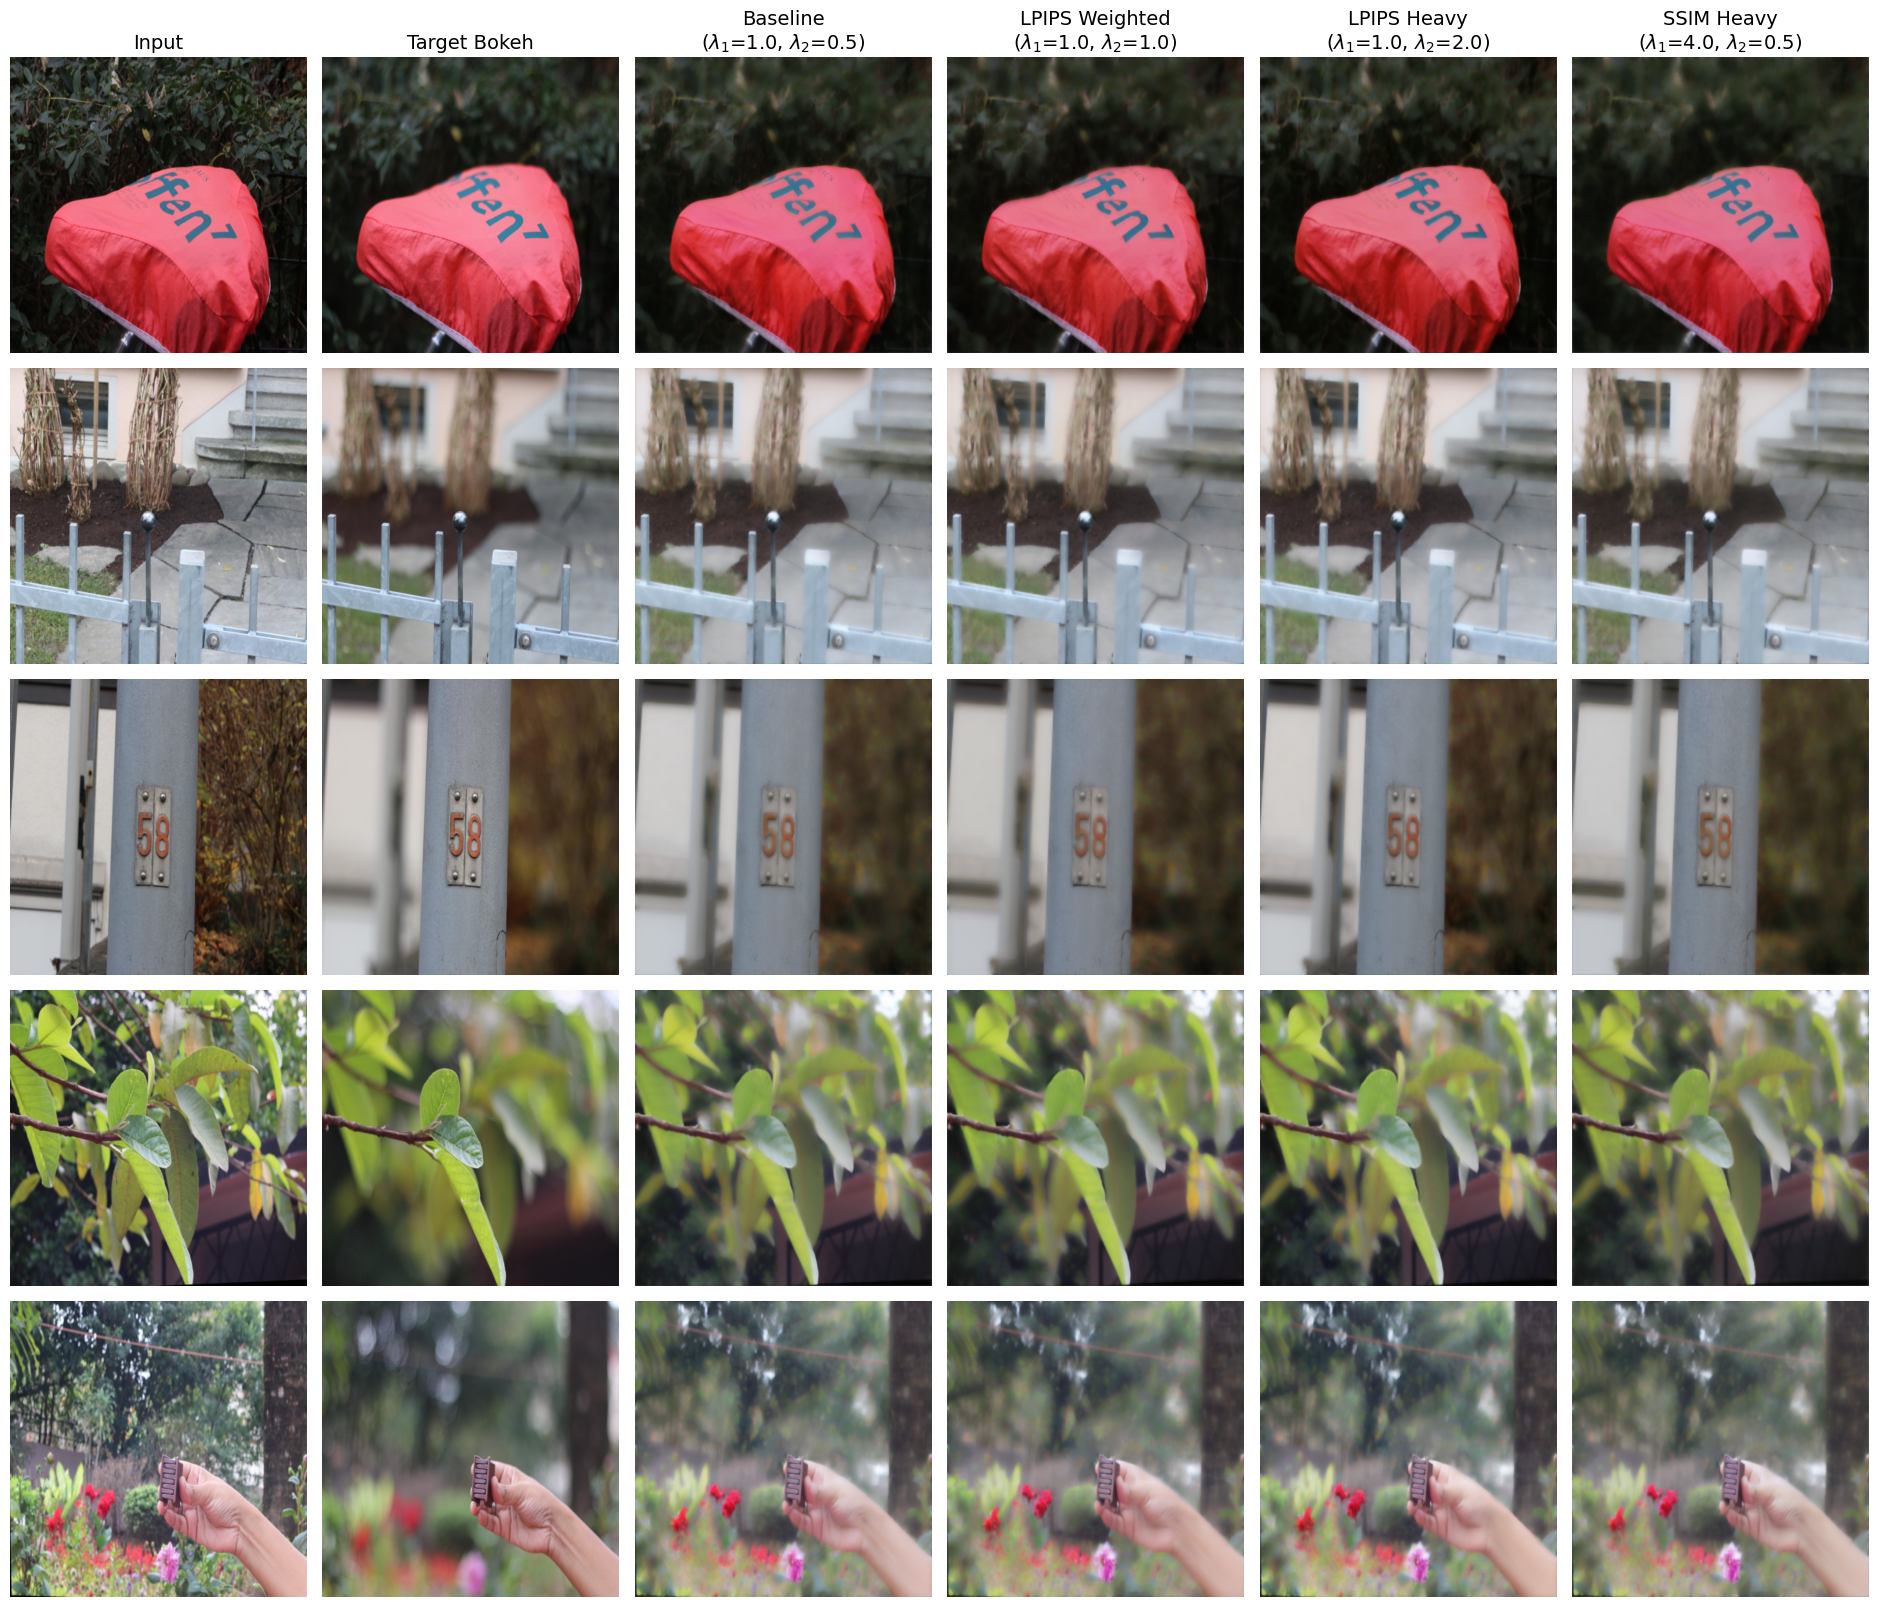


--- Qualitative Comparison Plot Generation Complete ---


In [ ]:
# @title QUALITATIVE ANALYSIS OF LOSS WEIGHTS (Figure 1)

# reusing bokeh_CNN class definition here with batchnorm
class bokeh_CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(bokeh_CNN, self).__init__(); features = init_features
        self.enc1=nn.Sequential(nn.Conv2d(in_channels, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True), nn.Conv2d(features, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True)); self.pool1=nn.MaxPool2d(2, 2)
        self.enc2=nn.Sequential(nn.Conv2d(features, features * 2, 3, padding=1, bias=False), nn.BatchNorm2d(features * 2), nn.ReLU(True), nn.Conv2d(features * 2, features * 2, 3, padding=1, bias=False), nn.BatchNorm2d(features * 2), nn.ReLU(True)); self.pool2=nn.MaxPool2d(2, 2)
        self.enc3=nn.Sequential(nn.Conv2d(features * 2, features * 4, 3, padding=1, bias=False), nn.BatchNorm2d(features * 4), nn.ReLU(True), nn.Conv2d(features * 4, features * 4, 3, padding=1, bias=False), nn.BatchNorm2d(features * 4), nn.ReLU(True)); self.up2=nn.ConvTranspose2d(features * 4, features * 2, 2, stride=2)
        self.dec2=nn.Sequential(nn.Conv2d(features * 4, features * 2, 3, padding=1, bias=False), nn.BatchNorm2d(features * 2), nn.ReLU(True), nn.Conv2d(features * 2, features * 2, 3, padding=1, bias=False), nn.BatchNorm2d(features * 2), nn.ReLU(True)); self.up1=nn.ConvTranspose2d(features * 2, features, 2, stride=2)
        self.dec1=nn.Sequential(nn.Conv2d(features * 2, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True), nn.Conv2d(features, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True)); self.output_conv=nn.Conv2d(features, out_channels, 1)
    def forward(self, x):
        try:
            x1=self.enc1(x); p1=self.pool1(x1); x2=self.enc2(p1); p2=self.pool2(x2); x3=self.enc3(p2)
            u2=self.up2(x3); diffY=x2.size(2)-u2.size(2); diffX=x2.size(3)-u2.size(3); u2=F.pad(u2,[diffX//2,diffX-diffX//2,diffY//2,diffY-diffY//2]); cat2=torch.cat([u2,x2],dim=1)
            x4=self.dec2(cat2); u1=self.up1(x4); diffY=x1.size(2)-u1.size(2); diffX=x1.size(3)-u1.size(3); u1=F.pad(u1,[diffX//2,diffX-diffX//2,diffY//2,diffY-diffY//2]); cat1=torch.cat([u1,x1],dim=1)
            x5=self.dec1(cat1); out=self.output_conv(x5); return torch.sigmoid(out)
        except Exception as e: print(f"Error in bokeh_CNN forward pass: {e}"); traceback.print_exc(); raise


BASE_PATH = '/content/ebb_dataset/'

SAVE_DIR = "/content/drive/MyDrive/Bokeh_MiniLoop_Runs"

MODEL_CONFIG = {'in_channels': 3, 'out_channels': 3, 'init_features': 32}
IMG_SIZE = 512

# my chosen files with 'challenging' scenes which i wanted to do qualitative analysis on
SELECTED_FILENAMES = [
    "1724.jpg",
    "2086.jpg",
    "2013.jpg",
    "3591.jpg",
    "3588.jpg",
]


MODELS_TO_LOAD = [
    ("Baseline", 1.0, 0.5, os.path.join(SAVE_DIR, "/content/drive/MyDrive/Bokeh_MiniLoop_Runs/Mini_VUNet_IF128_LW_S1.0_P0.5_B4_E10_model.pth")), # <<< FILENAME from Run 1
    ("LPIPS Weighted", 1.0, 1.0, os.path.join(SAVE_DIR, "Mini_VUNet_IF32_LW_S1.0_P1.0_B4_E10_model.pth")), # UPDATE FILENAME AS NEEDED
    ("LPIPS Heavy", 1.0, 2.0, os.path.join(SAVE_DIR, "Mini_VUNet_IF32_LW_S1.0_P2.0_B4_E10_model.pth")), # UPDATE FILENAME AS NEEDED
    ("SSIM Heavy", 4.0, 0.5, os.path.join(SAVE_DIR, "Mini_VUNet_IF32_LW_S4.0_P0.5_B4_E10_model.pth")), # UPDATE FILENAME AS NEEDED
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_pil = ToPILImage()

transform_model_input = Compose([Resize((IMG_SIZE, IMG_SIZE)), ToTensor()])

resize_display = Resize((IMG_SIZE, IMG_SIZE))


print(f"\n--- Collecting data for {len(SELECTED_FILENAMES)} images and {len(MODELS_TO_LOAD)} models ---")
collected_data = []

comparison_original_dir = os.path.join(BASE_PATH, 'validation/original')
comparison_bokeh_dir = os.path.join(BASE_PATH, 'validation/bokeh')
print(f"Loading images for comparison from: {comparison_original_dir}")

# loading models
model_instances = {}
for label_prefix, s_w, p_w, model_path in MODELS_TO_LOAD:
    label = f"{label_prefix} ($\\lambda_1$={s_w:.1f}, $\\lambda_2$={p_w:.1f})" # Lambda 1 = SSIM, Lambda 2 = LPIPS
    print(f"Loading model weights for: {label}")
    if not os.path.exists(model_path):
         print(f"  WARNING - Model file not found: {model_path}")
         model_instances[label] = None; continue
    try:
        model = bokeh_CNN(**MODEL_CONFIG).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval(); model_instances[label] = model
    except Exception as load_err: print(f"  ERROR loading state dict for {label}: {load_err}"); model_instances[label] = None

# loop through th selected images from the validation set ---
for filename in tqdm(SELECTED_FILENAMES, desc="Processing Images"):
    original_path = os.path.join(comparison_original_dir, filename)
    target_path = os.path.join(comparison_bokeh_dir, filename)
    image_data = {'filename': filename, 'input_pil': None, 'target_pil': None, 'outputs': {}}
    if not os.path.exists(original_path) or not os.path.exists(target_path): print(f"Skipping {filename} - File not found."); collected_data.append(image_data); continue

    try:
        original_pil = Image.open(original_path).convert('RGB'); target_pil = Image.open(target_path).convert('RGB')
        image_data['input_pil'] = resize_display(original_pil); image_data['target_pil'] = resize_display(target_pil) # store resized for display
        input_tensor = transform_model_input(original_pil).unsqueeze(0).to(device)

        for label, model in model_instances.items():
            if model is None: image_data['outputs'][label] = None; continue
            try:
                with torch.no_grad(): output_tensor = model(input_tensor)
                output_tensor_clamped = torch.clamp(output_tensor.squeeze(0).cpu(), 0.0, 1.0); output_pil = to_pil(output_tensor_clamped)
                image_data['outputs'][label] = output_pil
            except Exception as inference_err: print(f"ERROR during inference for {filename} with model {label}: {inference_err}"); image_data['outputs'][label] = None
        collected_data.append(image_data)
    except Exception as e: print(f"ERROR processing file {filename}: {e}"); traceback.print_exc(); collected_data.append(image_data) # Add placeholder on error

print("\n--- Data Collection Complete ---")

# plotting qualitiative plot
print("\n--- Generating Consolidated Plot ---")
num_images = len(collected_data); num_models = len(MODELS_TO_LOAD); num_cols = 2 + num_models
if num_images == 0: print("No data collected to plot.")
else:
    base_width_per_plot = 4; fig_width = base_width_per_plot * num_cols; fig_height = base_width_per_plot * num_images
    fig, axs = plt.subplots(num_images, num_cols, figsize=(fig_width, fig_height), squeeze=False)

    for row_idx, data in enumerate(collected_data):
        ax_in = axs[row_idx, 0]; ax_tgt = axs[row_idx, 1]
        if data['input_pil']: ax_in.imshow(data['input_pil'])
        else: ax_in.text(0.5, 0.5, 'Input Error', ha='center', va='center', color='red', transform=ax_in.transAxes)
        if row_idx == 0: ax_in.set_title("Input", fontsize=14)
        if data['target_pil']: ax_tgt.imshow(data['target_pil'])
        else: ax_tgt.text(0.5, 0.5, 'Target Error', ha='center', va='center', color='red', transform=ax_tgt.transAxes)
        if row_idx == 0: ax_tgt.set_title("Target Bokeh", fontsize=14)

        col_idx = 2
        for label_prefix, s_w, p_w, _ in MODELS_TO_LOAD:
             label = f"{label_prefix} ($\\lambda_1$={s_w:.1f}, $\\lambda_2$={p_w:.1f})" # Lambda1=SSIM, Lambda2=LPIPS
             current_ax = axs[row_idx, col_idx]
             output_img = data['outputs'].get(label, None)
             if output_img: current_ax.imshow(output_img)
             else: current_ax.text(0.5, 0.5, 'Error/Missing', ha='center', va='center', fontsize=10, color='red', transform=current_ax.transAxes)
             if row_idx == 0: title = f"{label_prefix}\n($\\lambda_1$={s_w:.1f}, $\\lambda_2$={p_w:.1f})"; current_ax.set_title(title, fontsize=14)
             col_idx += 1

    for ax in axs.flat: ax.set_aspect('equal', adjustable='box'); ax.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05); print("Displaying plot..."); plt.show()

print("\n--- Qualitative Comparison Plot Generation Complete ---")

# 6. Training loop

Models/Checkpoints will be saved in: /content/drive/MyDrive/Bokeh_Training_Runs
--- Running on device: cuda ---
Defined unified transform (No Augmentation).
Loading full original training dataset index for subsetting...
Created Training Subset of size: 2048
Loading full new 'validation' dataset...
Found 938 pairs in 'validation'.
Loading full 'test' dataset...
Found 200 pairs in 'test'.

DataLoaders created (Batch Size: 4): Train (512 batches), Validation (235 batches), Test (50 batches)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 247MB/

Model, Optimizer, Loss, Scheduler instantiated.
No checkpoint found. Starting training from scratch.

--- Starting Final Training Run: VUNetDeep_IF64_B4_E50_ES6_LRsch3_Sub2048_Final ---


Epoch 1/30 - Train Loss: 0.9335 - Val Loss: 0.7696 - Val L1: 0.1488 - Time: 495.52s
  New best validation loss: 0.7696. Saving best model...
  Saving checkpoint at epoch 1...


Epoch 2/30 - Train Loss: 0.8598 - Val Loss: 0.7759 - Val L1: 0.1581 - Time: 497.61s
  Validation loss did not improve. ES Patience: 1/6


Epoch 3/30 - Train Loss: 0.8276 - Val Loss: 0.7151 - Val L1: 0.1444 - Time: 498.66s
  New best validation loss: 0.7151. Saving best model...
  Saving checkpoint at epoch 3...


Epoch 4/30 - Train Loss: 0.7969 - Val Loss: 0.7084 - Val L1: 0.1441 - Time: 500.55s
  New best validation loss: 0.7084. Saving best model...
  Saving checkpoint at epoch 4...


Epoch 5/30 - Train Loss: 0.7638 - Val Loss: 0.6853 - Val L1: 0.1427 - Time: 501.07s
  New best validation loss: 0.6853. Saving best model...
  Saving checkpoint at epoch 5...


Epoch 6/30 - Train Loss: 0.7442 - Val Loss: 0.6700 - Val L1: 0.1426 - Time: 500.86s
  New best validation loss: 0.6700. Saving best model...
  Saving checkpoint at epoch 6...


Epoch 7/30 - Train Loss: 0.7286 - Val Loss: 0.6490 - Val L1: 0.1397 - Time: 501.65s
  New best validation loss: 0.6490. Saving best model...
  Saving checkpoint at epoch 7...


Epoch 8/30 - Train Loss: 0.7130 - Val Loss: 0.6462 - Val L1: 0.1409 - Time: 501.02s
  New best validation loss: 0.6462. Saving best model...
  Saving checkpoint at epoch 8...


Epoch 9/30 - Train Loss: 0.7073 - Val Loss: 0.6640 - Val L1: 0.1424 - Time: 500.57s
  Validation loss did not improve. ES Patience: 1/6


Epoch 10/30 - Train Loss: 0.6957 - Val Loss: 0.6292 - Val L1: 0.1363 - Time: 501.57s
  New best validation loss: 0.6292. Saving best model...
  Saving checkpoint at epoch 10...


Epoch 11/30 - Train Loss: 0.6935 - Val Loss: 0.6303 - Val L1: 0.1375 - Time: 500.54s
  Validation loss did not improve. ES Patience: 1/6


Epoch 12/30 - Train Loss: 0.6828 - Val Loss: 0.6256 - Val L1: 0.1385 - Time: 500.77s
  New best validation loss: 0.6256. Saving best model...
  Saving checkpoint at epoch 12...


Epoch 13/30 - Train Loss: 0.6758 - Val Loss: 0.6289 - Val L1: 0.1374 - Time: 501.46s
  Validation loss did not improve. ES Patience: 1/6


Epoch 14/30 - Train Loss: 0.6742 - Val Loss: 0.6671 - Val L1: 0.1514 - Time: 501.68s
  Validation loss did not improve. ES Patience: 2/6


Epoch 15/30 - Train Loss: 0.6696 - Val Loss: 0.6418 - Val L1: 0.1412 - Time: 501.48s
  Validation loss did not improve. ES Patience: 3/6
  Saving checkpoint at epoch 15...


Epoch 16/30 - Train Loss: 0.6669 - Val Loss: 0.6392 - Val L1: 0.1415 - Time: 501.70s
  Validation loss did not improve. ES Patience: 4/6


Epoch 17/30 - Train Loss: 0.6383 - Val Loss: 0.6056 - Val L1: 0.1342 - Time: 502.07s
  New best validation loss: 0.6056. Saving best model...
  Saving checkpoint at epoch 17...


Epoch 18/30 - Train Loss: 0.6299 - Val Loss: 0.6163 - Val L1: 0.1419 - Time: 502.54s
  Validation loss did not improve. ES Patience: 1/6


Epoch 19/30 - Train Loss: 0.6297 - Val Loss: 0.6060 - Val L1: 0.1355 - Time: 501.84s
  Validation loss did not improve. ES Patience: 2/6


Epoch 20/30 - Train Loss: 0.6255 - Val Loss: 0.6040 - Val L1: 0.1349 - Time: 501.88s
  New best validation loss: 0.6040. Saving best model...
  Saving checkpoint at epoch 20...


Epoch 21/30 - Train Loss: 0.6238 - Val Loss: 0.5965 - Val L1: 0.1324 - Time: 502.66s
  New best validation loss: 0.5965. Saving best model...
  Saving checkpoint at epoch 21...


Epoch 22/30 - Train Loss: 0.6200 - Val Loss: 0.6025 - Val L1: 0.1352 - Time: 501.96s
  Validation loss did not improve. ES Patience: 1/6


Epoch 23/30 - Train Loss: 0.6208 - Val Loss: 0.5988 - Val L1: 0.1347 - Time: 502.83s
  Validation loss did not improve. ES Patience: 2/6


Epoch 24/30 - Train Loss: 0.6194 - Val Loss: 0.5932 - Val L1: 0.1326 - Time: 502.02s
  New best validation loss: 0.5932. Saving best model...
  Saving checkpoint at epoch 24...


Epoch 25/30 - Train Loss: 0.6170 - Val Loss: 0.5988 - Val L1: 0.1327 - Time: 501.62s
  Validation loss did not improve. ES Patience: 1/6
  Saving checkpoint at epoch 25...


Epoch 26/30 - Train Loss: 0.6163 - Val Loss: 0.6025 - Val L1: 0.1358 - Time: 503.12s
  Validation loss did not improve. ES Patience: 2/6


Epoch 27/30 - Train Loss: 0.6149 - Val Loss: 0.5970 - Val L1: 0.1338 - Time: 501.44s
  Validation loss did not improve. ES Patience: 3/6


Epoch 28/30 - Train Loss: 0.6144 - Val Loss: 0.5949 - Val L1: 0.1323 - Time: 502.40s
  Validation loss did not improve. ES Patience: 4/6


Epoch 29/30 - Train Loss: 0.6077 - Val Loss: 0.5883 - Val L1: 0.1330 - Time: 502.91s
  New best validation loss: 0.5883. Saving best model...
  Saving checkpoint at epoch 29...


Epoch 30/30 - Train Loss: 0.6064 - Val Loss: 0.5923 - Val L1: 0.1324 - Time: 503.25s
  Validation loss did not improve. ES Patience: 1/6
  Saving checkpoint at epoch 30...

--- Training Finished (250.75 mins over 30 epochs this run) ---

--- Evaluating Best Model on DEDICATED Test Set ---
Loading best model from: /content/drive/MyDrive/Bokeh_Training_Runs/VUNetDeep_IF64_B4_E50_ES6_LRsch3_Sub2048_Final_best_model.pth


Final Test Eval & Inference Timing: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]



--- Plotting Losses ---
Loss plot saved to: /content/drive/MyDrive/Bokeh_Training_Runs/VUNetDeep_IF64_B4_E50_ES6_LRsch3_Sub2048_Final_loss_plot.png


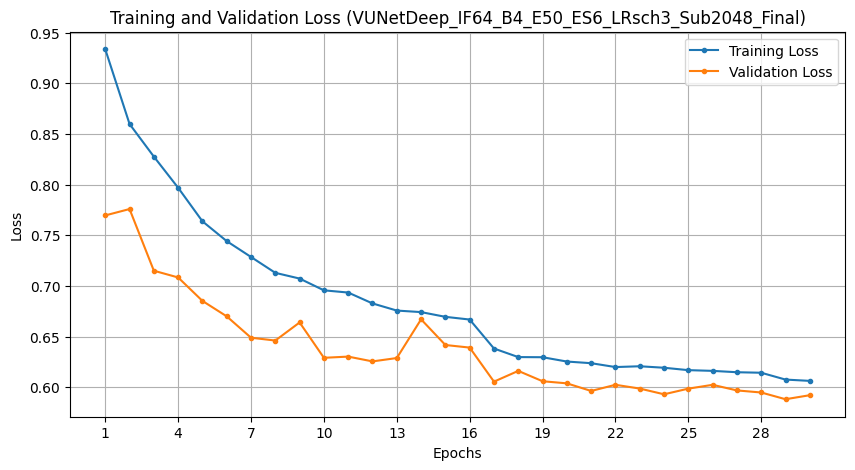


--- Final Performance Report ---
Run ID: VUNetDeep_IF64_B4_E50_ES6_LRsch3_Sub2048_Final
Dataset: Train Subset (2048), Full Validation, Full Test (No Augmentation)
Total Training Time: 250.75 minutes (30 epochs this run / 30 total epochs)
Best Val Loss Achieved: 0.5883
Final Avg Training Loss (at end of run): 0.6064
----------------------------------------
FINAL Test Set Performance (Best Model):
  Avg Test Loss (Total): 0.5512
  Avg Test L1 Loss Comp: 0.1321
  PSNR:                  24.12 dB
  SSIM (skimage):        0.8568
  MS-SSIM:               0.8969
  LPIPS (AlexNet):       0.1532
  Avg Inference Time:    65.22 ms/image (T4 GPU)
----------------------------------------

Best model (based on validation loss) saved at: /content/drive/MyDrive/Bokeh_Training_Runs/VUNetDeep_IF64_B4_E50_ES6_LRsch3_Sub2048_Final_best_model.pth
Final periodic checkpoint saved at: /content/drive/MyDrive/Bokeh_Training_Runs/VUNetDeep_IF64_B4_E50_ES6_LRsch3_Sub2048_Final_checkpoint.pth


In [ ]:
# @title FINAL TRAINING LOOP VANILLA U-NET (BASED ON VBASE_3) - RESULTS SECTION

torch.manual_seed(42) # for reproducibility
np.random.seed(42)

BASE_PATH = '/content/ebb_dataset/'
DRIVE_SAVE_DIR = "/content/drive/MyDrive/Bokeh_Training_Runs"

RUN_ID = "VUNetDeep_IF64_B4_E50_ES6_LRsch3_Sub2048_Final"

MODEL_HP = {
    'in_channels': 3,
    'out_channels': 3,
    'init_features': 64
}
DEPTH_LEVELS = 4 # deeper model for final loop due to better performance

#hyperparam.'s
TRAINING_HP = {
    'learning_rate': 2e-4, # starting LR (aggressive )
    'batch_size': 4,
    'target_epochs': 30,
    'grad_clip': 1.0,
}
TRAIN_SUBSET_SIZE = 2048 # for efficiencyy

EARLY_STOPPING_PATIENCE = 6
CHECKPOINT_FREQ = 5       # saving every 5 epochs to drive just incase runtime disconn.

# LR Scheduler Config
SCHEDULER_PATIENCE = 3 # <<< Patience = 3 for LR reduction
SCHEDULER_FACTOR = 0.2 # reduces by 20%

# Image/Evaluation Settings
IMG_SIZE = 512
EVAL_CROP_BORDER = 32
EVAL_SSIM_WIN_SIZE = 11

#  Ensure Save Directory Exists
CHECKPOINT_PATH = os.path.join(DRIVE_SAVE_DIR, f"{RUN_ID}_checkpoint.pth")
BEST_MODEL_PATH = os.path.join(DRIVE_SAVE_DIR, f"{RUN_ID}_best_model.pth")
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)
print(f"Models/Checkpoints will be saved in: {DRIVE_SAVE_DIR}")


### Class definitions, some repeated for individual cell runs ###

class BokehDataset(Dataset):
    def __init__(self, original_dir, bokeh_dir, transform=None):
        self.original_dir=original_dir; self.bokeh_dir=bokeh_dir; self.transform=transform
        if not os.path.isdir(self.original_dir): raise FileNotFoundError(f"Dir not found: {self.original_dir}")
        if not os.path.isdir(self.bokeh_dir): raise FileNotFoundError(f"Dir not found: {self.bokeh_dir}")
        try:
            original_files=set(f for f in os.listdir(original_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.JPG')))
            bokeh_files=set(f for f in os.listdir(bokeh_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.JPG')))
        except FileNotFoundError: print(f"Warning: Error listing files."); original_files, bokeh_files = set(), set()
        self.image_names=sorted(list(original_files.intersection(bokeh_files)))
        if not self.image_names: print(f"Warning: No matching image pairs found in {original_dir} and {bokeh_dir}")
    def __len__(self): return len(self.image_names)
    def __getitem__(self, idx):
        if idx >= len(self.image_names): raise IndexError("Index out of bounds")
        img_name=self.image_names[idx]; original_path=os.path.join(self.original_dir, img_name); bokeh_path=os.path.join(self.bokeh_dir, img_name)
        try:
            if not os.path.exists(original_path) or not os.path.exists(bokeh_path): return None, None
            with Image.open(original_path) as img_o, Image.open(bokeh_path) as img_b: original_image=img_o.convert('RGB'); bokeh_image=img_b.convert('RGB')
            if self.transform: input_tensor=self.transform(original_image); target_tensor=self.transform(bokeh_image)
            else: return original_image, bokeh_image
            if not isinstance(input_tensor, torch.Tensor) or not isinstance(target_tensor, torch.Tensor): return None, None
            return input_tensor, target_tensor
        except Exception as e:
             return None, None

class WeightedPyNetPerceptualLoss(nn.Module):
    def __init__(self, fg_weight: float = 2.0, bg_weight: float = 1.0, max_levels: int = 3, level_weights: list = None, lpips_weight: float = 1.0, ssim_weight: float = 1.0):
        super().__init__(); self.fg_w, self.bg_w = fg_weight, bg_weight; self.max_levels = max_levels
        self.level_weights = level_weights or [1.0/(2**i) for i in range(max_levels+1)]
        if 'lpips' not in globals(): raise NameError("lpips library not imported or LPIPS class not found")
        self.lpips_fn = lpips.LPIPS(net='alex', verbose=False).eval(); self.lpips_weight = lpips_weight; self.ssim_weight  = ssim_weight
        lap = torch.tensor([[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]]); self.register_buffer('lap_kernel', lap.unsqueeze(0).unsqueeze(0))
    def gaussian_pyramid(self, img: torch.Tensor, max_levels: int) -> list:
         k1d = torch.tensor([1.,4.,6.,4.,1.], device=img.device) / 16.; ker = (k1d[:,None] * k1d[None,:]).unsqueeze(0).unsqueeze(0).repeat(img.size(1),1,1,1)
         pyr = [img]; cur = img
         for _ in range(max_levels):
             try: blurred = F.conv2d(F.pad(cur, (2,2,2,2), mode='reflect'), ker, groups=img.size(1)); cur = blurred[:, :, ::2, ::2]; pyr.append(cur)
             except Exception as e: print(f"Error in gaussian_pyramid conv: {e}"); break
         return pyr
    def generate_focus_mask(self, img: torch.Tensor, threshold: float = 0.03) -> torch.Tensor:
         if img.shape[1] != 3: print("Warning: Generating focus mask from non-3-channel image.")
         try: img_float = img.float(); gray = img_float.mean(dim=1, keepdim=True); lap_kernel_device = self.lap_kernel.to(gray.device); lap = F.conv2d(F.pad(gray, (1,1,1,1), mode='reflect'), lap_kernel_device); return (lap.abs() > threshold).float().to(img.device)
         except Exception as e: print(f"Error generating focus mask: {e}"); return torch.ones_like(img[:, 0:1, :, :])
    def forward(self, pred: torch.Tensor, target: torch.Tensor, original: torch.Tensor) -> (torch.Tensor, dict):
         pred_device = pred.device; target = target.to(pred_device); original = original.to(pred_device)
         l1_loss, ssim_loss = 0.0, 0.0; loss_components = {}
         try:
             mask_full = self.generate_focus_mask(original); pred = torch.clamp(pred, 0.0, 1.0); target = torch.clamp(target, 0.0, 1.0)
             pred_pyr = self.gaussian_pyramid(pred, self.max_levels); tgt_pyr  = self.gaussian_pyramid(target, self.max_levels)
             if len(pred_pyr) != len(tgt_pyr): raise ValueError(f"Pyramid lengths differ: Pred {len(pred_pyr)}, Target {len(tgt_pyr)}")
             for lvl, (p, t) in enumerate(zip(pred_pyr, tgt_pyr)):
                 if p.shape != t.shape: continue
                 w_lvl = self.level_weights[lvl]; mask_lvl = F.interpolate(mask_full, size=p.shape[2:], mode='nearest'); pixel_w = mask_lvl * self.fg_w + (1 - mask_lvl) * self.bg_w
                 l1 = (p - t).abs(); weighted_l1_map = l1 * pixel_w; current_l1_loss = w_lvl * weighted_l1_map.mean(); l1_loss += current_l1_loss; loss_components[f'l1_lvl_{lvl}'] = current_l1_loss.item()
                 try: ssim_val = ssim_pytorch(p, t, data_range=1.0, size_average=True); avg_w = pixel_w.mean(); current_ssim_loss = w_lvl * (1 - ssim_val) * avg_w; ssim_loss += current_ssim_loss; loss_components[f'ssim_lvl_{lvl}'] = current_ssim_loss.item()
                 except Exception: loss_components[f'ssim_lvl_{lvl}'] = 0.0
             try: lpips_loss_val = self.lpips_fn(pred * 2.0 - 1.0, target * 2.0 - 1.0).mean(); loss_components['lpips'] = lpips_loss_val.item() * self.lpips_weight
             except Exception: lpips_loss_val = torch.tensor(0.0).to(pred_device); loss_components['lpips'] = 0.0
             total = l1_loss + self.ssim_weight * ssim_loss + self.lpips_weight * lpips_loss_val
             loss_components['l1_multi_weighted'] = l1_loss.item(); loss_components['ssim_multi_weighted'] = ssim_loss.item() * self.ssim_weight
             return total, loss_components
         except Exception as e: print(f"ERROR in WeightedPyNetPerceptualLoss forward pass: {e}"); traceback.print_exc(); return torch.tensor(0.0, device=pred_device, requires_grad=True), {}

class bokeh_CNN_Deeper(nn.Module): # deeper lvel 4 CNN used for the final loop
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(bokeh_CNN_Deeper, self).__init__(); features = init_features
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True), nn.Conv2d(features, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True)); self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = nn.Sequential(nn.Conv2d(features, features*2, 3, padding=1, bias=False), nn.BatchNorm2d(features*2), nn.ReLU(True), nn.Conv2d(features*2, features*2, 3, padding=1, bias=False), nn.BatchNorm2d(features*2), nn.ReLU(True)); self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = nn.Sequential(nn.Conv2d(features*2, features*4, 3, padding=1, bias=False), nn.BatchNorm2d(features*4), nn.ReLU(True), nn.Conv2d(features*4, features*4, 3, padding=1, bias=False), nn.BatchNorm2d(features*4), nn.ReLU(True)); self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = nn.Sequential(nn.Conv2d(features*4, features*8, 3, padding=1, bias=False), nn.BatchNorm2d(features*8), nn.ReLU(True), nn.Conv2d(features*8, features*8, 3, padding=1, bias=False), nn.BatchNorm2d(features*8), nn.ReLU(True))
        self.up3 = nn.ConvTranspose2d(features*8, features*4, 2, stride=2); self.dec3 = nn.Sequential(nn.Conv2d(features*8, features*4, 3, padding=1, bias=False), nn.BatchNorm2d(features*4), nn.ReLU(True), nn.Conv2d(features*4, features*4, 3, padding=1, bias=False), nn.BatchNorm2d(features*4), nn.ReLU(True))
        self.up2 = nn.ConvTranspose2d(features*4, features*2, 2, stride=2); self.dec2 = nn.Sequential(nn.Conv2d(features*4, features*2, 3, padding=1, bias=False), nn.BatchNorm2d(features*2), nn.ReLU(True), nn.Conv2d(features*2, features*2, 3, padding=1, bias=False), nn.BatchNorm2d(features*2), nn.ReLU(True))
        self.up1 = nn.ConvTranspose2d(features*2, features, 2, stride=2); self.dec1 = nn.Sequential(nn.Conv2d(features*2, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True), nn.Conv2d(features, features, 3, padding=1, bias=False), nn.BatchNorm2d(features), nn.ReLU(True))
        self.output_conv = nn.Conv2d(features, out_channels, 1, bias=True)
    def forward(self, x):
        try:
            x1=self.enc1(x); p1=self.pool1(x1); x2=self.enc2(p1); p2=self.pool2(x2); x3=self.enc3(p2); p3=self.pool3(x3); x4=self.enc4(p3)
            u3=self.up3(x4); dY=x3.size(2)-u3.size(2); dX=x3.size(3)-u3.size(3); u3=F.pad(u3,[dX//2,dX-dX//2,dY//2,dY-dY//2]); cat3=torch.cat([u3,x3],dim=1); d3=self.dec3(cat3)
            u2=self.up2(d3); dY=x2.size(2)-u2.size(2); dX=x2.size(3)-u2.size(3); u2=F.pad(u2,[dX//2,dX-dX//2,dY//2,dY-dY//2]); cat2=torch.cat([u2,x2],dim=1); d2=self.dec2(cat2)
            u1=self.up1(d2); dY=x1.size(2)-u1.size(2); dX=x1.size(3)-u1.size(3); u1=F.pad(u1,[dX//2,dX-dX//2,dY//2,dY-dY//2]); cat1=torch.cat([u1,x1],dim=1); d1=self.dec1(cat1)
            out=self.output_conv(d1); return torch.sigmoid(out)
        except Exception as e: print(f"Error in bokeh_CNN_Deeper forward pass: {e}"); traceback.print_exc(); raise


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running on device: {device} ---")

# single transform, no augm.
transform_no_aug = Compose([Resize((IMG_SIZE, IMG_SIZE)), ToTensor()])
print("Defined unified transform (No Augmentation).")

# datasets & loaders
train_loader = None; val_loader = None; test_loader = None
try:
    if 'BASE_PATH' not in globals() or not os.path.isdir(BASE_PATH): raise ValueError("'BASE_PATH' not defined")
    original_train_dir=os.path.join(BASE_PATH, 'train/original'); bokeh_train_dir=os.path.join(BASE_PATH, 'train/bokeh')
    new_val_original_dir=os.path.join(BASE_PATH, 'validation/original'); new_val_bokeh_dir=os.path.join(BASE_PATH, 'validation/bokeh')
    test_original_dir = os.path.join(BASE_PATH, 'test/original'); test_bokeh_dir = os.path.join(BASE_PATH, 'test/bokeh')


    print("Loading full original training dataset index for subsetting...")
    full_new_train_dataset = BokehDataset(original_dir=original_train_dir, bokeh_dir=bokeh_train_dir, transform=transform_no_aug)
    num_actual_train_samples = len(full_new_train_dataset); assert num_actual_train_samples > 0
    # training subset creation
    train_subset_size = min(TRAIN_SUBSET_SIZE, num_actual_train_samples)
    train_dataset_subset, _ = random_split(full_new_train_dataset, [train_subset_size, num_actual_train_samples - train_subset_size], generator=torch.Generator().manual_seed(42))
    print(f"Created Training Subset of size: {len(train_dataset_subset)}")

    # load FULL val. dataset
    print("Loading full new 'validation' dataset...")
    val_dataset = BokehDataset(original_dir=new_val_original_dir, bokeh_dir=new_val_bokeh_dir, transform=transform_no_aug)
    num_actual_val_samples = len(val_dataset); assert num_actual_val_samples > 0
    print(f"Found {num_actual_val_samples} pairs in 'validation'.")

    # Lload FULL test dataset
    if os.path.isdir(test_original_dir) and os.path.isdir(test_bokeh_dir):
        print("Loading full 'test' dataset...")
        test_dataset = BokehDataset(original_dir=test_original_dir, bokeh_dir=test_bokeh_dir, transform=transform_no_aug)
        print(f"Found {len(test_dataset)} pairs in 'test'.")
        if len(test_dataset) == 0: test_dataset = None # Handle empty test set
    else: print("Test dataset directory not found."); test_dataset = None

    # create dataloaders
    def collate_fn_skip_none(batch): batch=list(filter(lambda x: x is not None and x[0] is not None and x[1] is not None, batch)); return torch.utils.data.dataloader.default_collate(batch) if batch else None
    num_workers = 2; BATCH_SIZE = TRAINING_HP['batch_size']

    train_loader = DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_skip_none, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_skip_none)
    test_loader = None
    if test_dataset: test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn_skip_none)
    print(f"\nDataLoaders created (Batch Size: {BATCH_SIZE}): Train ({len(train_loader)} batches), Validation ({len(val_loader)} batches){f', Test ({len(test_loader)} batches)' if test_loader else ', No Test Loader'}")
    assert len(train_loader)>0 and len(val_loader)>0

except Exception as e: print(f"Error setting up Datasets/DataLoaders: {e}"); raise

# -- Model, Optimizer, Loss, Scheduler - -
#  Instantiate the DEEPER model (Lvl4)
model = bokeh_CNN_Deeper(**MODEL_HP).to(device) # MODEL_HP uses init_features=64
optimizer = optim.Adam(model.parameters(), lr=TRAINING_HP['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=True)
try:
    criterion = WeightedPyNetPerceptualLoss(lpips_weight=0.5, ssim_weight=1.0).to(device); lpips_eval_fn = lpips.LPIPS(net='alex', verbose=False).to(device)
    print("Model, Optimizer, Loss, Scheduler instantiated.")
except Exception as e: print(f"Error instantiating components: {e}"); raise

#  checkpoint loading -
start_epoch = 0; best_val_loss = float('inf'); history = {'train_loss': [], 'val_loss': [], 'val_l1_loss': []}
if os.path.exists(CHECKPOINT_PATH):
    print(f"Attempting to load checkpoint: {CHECKPOINT_PATH}")
    try:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu'); model_state_dict = checkpoint['model_state_dict']
        # loading state dict for the deeper model
        model.load_state_dict(model_state_dict); model.to(device);
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
             for k, v in state.items():
                 if isinstance(v, torch.Tensor): state[k] = v.to(device)
        start_epoch = checkpoint['epoch'] + 1; best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        if 'history' in checkpoint: history = checkpoint['history']; print(f"Loaded history with {len(history.get('train_loss',[]))} epochs.")
        else: history = {'train_loss': [], 'val_loss': [], 'val_l1_loss': []} # init if missing
        if 'scheduler_state_dict' in checkpoint: scheduler.load_state_dict(checkpoint['scheduler_state_dict']); print("Loaded LR scheduler state.")
        print(f"Resuming training from Epoch {start_epoch}, Best Val Loss: {best_val_loss:.4f}")
    except RuntimeError as e: print(f"Error loading state_dict (likely model mismatch): {e}. Starting fresh."); start_epoch = 0; best_val_loss = float('inf'); history = {'train_loss': [], 'val_loss': [], 'val_l1_loss': []}
    except Exception as e: print(f"Error loading checkpoint: {e}. Starting fresh."); start_epoch = 0; best_val_loss = float('inf'); history = {'train_loss': [], 'val_loss': [], 'val_l1_loss': []}
else: print("No checkpoint found. Starting training from scratch.")


# definining eval. function
def evaluate_model(model, dataloader, lpips_eval_fn, crop_border=0, ssim_win_size=11):
    model.eval(); eval_device = next(model.parameters()).device; total_psnr, total_ssim_sk, total_msssim, total_lpips = 0.0, 0.0, 0.0, 0.0; lpips_msssim_count, psnr_ssim_count = 0, 0
    if dataloader is None: return 0,0,0,0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False, disable=len(dataloader)<5):
            if batch is None: continue
            try: inputs, targets = batch; assert isinstance(inputs, torch.Tensor) and isinstance(targets, torch.Tensor)
            except (AssertionError, TypeError, ValueError): continue
            if inputs.shape[1] != 3 or targets.shape[1] != 3: continue
            inputs, targets = inputs.to(eval_device), targets.to(eval_device); outputs = model(inputs)
            outputs_clipped = torch.clamp(outputs, 0.0, 1.0); current_batch_size = outputs_clipped.shape[0]; outputs_lpips_input = outputs_clipped * 2.0 - 1.0; targets_lpips_input = targets * 2.0 - 1.0
            try: lpips_val = lpips_eval_fn(outputs_lpips_input, targets_lpips_input.detach()); total_lpips += lpips_val.sum().item(); lpips_msssim_count += current_batch_size
            except Exception: pass
            try: ms_ssim_val_batch = ms_ssim(outputs_clipped, targets.detach(), data_range=1.0, size_average=False); total_msssim += ms_ssim_val_batch.sum().item()
            except Exception: pass
            outputs_np_full = outputs_clipped.cpu().numpy(); targets_np_full = targets.cpu().numpy()
            for i in range(current_batch_size):
                out_img_full_np = np.transpose(outputs_np_full[i], (1, 2, 0)); tgt_img_full_np = np.transpose(targets_np_full[i], (1, 2, 0)); h, w = out_img_full_np.shape[:2]
                if crop_border > 0 and h > 2 * crop_border and w > 2 * crop_border: out_img_eval_np=out_img_full_np[crop_border:-crop_border, crop_border:-crop_border, :]; tgt_img_eval_np=tgt_img_full_np[crop_border:-crop_border, crop_border:-crop_border, :]
                else: out_img_eval_np=out_img_full_np; tgt_img_eval_np=tgt_img_full_np
                try:
                    psnr=psnr_metric_skimage(tgt_img_eval_np, out_img_eval_np, data_range=1.0); ch_sk, cw_sk = tgt_img_eval_np.shape[:2]; current_win_size=min(ssim_win_size, ch_sk, cw_sk)
                    if current_win_size % 2 == 0: current_win_size -= 1; current_win_size=max(3, current_win_size)
                    if ch_sk >= current_win_size and cw_sk >= current_win_size : ssim_val_sk=ssim_metric_skimage(tgt_img_eval_np, out_img_eval_np, channel_axis=-1, data_range=1.0, win_size=current_win_size, gaussian_weights=True, multichannel=True)
                    else: ssim_val_sk = np.nan
                    if not np.isnan(psnr) and not np.isnan(ssim_val_sk): total_psnr+=psnr; total_ssim_sk+=ssim_val_sk; psnr_ssim_count+=1
                except ValueError: pass
    avg_psnr=total_psnr/psnr_ssim_count if psnr_ssim_count>0 else 0; avg_ssim_sk=total_ssim_sk/psnr_ssim_count if psnr_ssim_count > 0 else 0; avg_msssim=total_msssim/lpips_msssim_count if lpips_msssim_count > 0 else 0; avg_lpips=total_lpips/lpips_msssim_count if lpips_msssim_count > 0 else 0
    return avg_psnr, avg_ssim_sk, avg_msssim, avg_lpips

# - train loop --
print(f"\n--- Starting Final Training Run: {RUN_ID} ---")
patience_counter = 0; training_start_time = time.time(); epochs_completed_this_run = 0
history.setdefault('train_loss', []); history.setdefault('val_loss', []); history.setdefault('val_l1_loss', [])

try:
    for epoch in range(start_epoch, TRAINING_HP['target_epochs']):
        epoch_start_time = time.time()

        model.train(); running_train_loss = 0.0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{TRAINING_HP['target_epochs']} [Train]", leave=False)
        for i, batch in pbar:

            if batch is None: continue
            try: inputs, targets = batch; assert isinstance(inputs, torch.Tensor) and isinstance(targets, torch.Tensor)
            except (AssertionError, TypeError, ValueError): continue
            if inputs.shape[1] != 3 or targets.shape[1] != 3: continue
            try:
                inputs, targets = inputs.to(device), targets.to(device); optimizer.zero_grad(); outputs = model(inputs); total_loss, _ = criterion(pred=outputs, target=targets, original=inputs)
                if torch.isnan(total_loss) or torch.isinf(total_loss): continue
                total_loss.backward();
                if 'GRAD_CLIP_VALUE' in globals() and GRAD_CLIP_VALUE: torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                optimizer.step(); running_train_loss += total_loss.item(); pbar.set_postfix({'Loss': f'{total_loss.item():.4f}'})
            except Exception as batch_err: print(f"Error processing train batch {i}: {batch_err}"); traceback.print_exc(); continue
        avg_train_loss = running_train_loss / len(train_loader) if len(train_loader) > 0 else 0
        if len(history['train_loss']) <= epoch: history['train_loss'].append(avg_train_loss)
        else: history['train_loss'][epoch] = avg_train_loss # overwrite if resuming

        # - validation phase
        model.eval(); running_val_loss = 0.0; running_val_l1_loss = 0.0; avg_val_l1_loss = float('nan')
        if len(val_loader) == 0: print("Warning: Val loader empty."); avg_val_loss = best_val_loss
        else:
            with torch.no_grad():
                for batch_val in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]", leave=False):
                    if batch_val is None: continue
                    try: inputs_val, targets_val = batch_val; assert isinstance(inputs_val, torch.Tensor) and isinstance(targets_val, torch.Tensor)
                    except (AssertionError, TypeError, ValueError): continue
                    if inputs_val.shape[1] != 3 or targets_val.shape[1] != 3: continue
                    try:
                        inputs_val, targets_val = inputs_val.to(device), targets_val.to(device); outputs_val = model(inputs_val)
                        val_total_loss, val_loss_components = criterion(pred=outputs_val, target=targets_val, original=inputs_val)
                        if torch.isnan(val_total_loss) or torch.isinf(val_total_loss): continue
                        running_val_loss += val_total_loss.item(); running_val_l1_loss += val_loss_components.get('l1_multi_weighted', 0.0)
                    except Exception as val_batch_err: print(f"Error processing validation batch: {val_batch_err}"); continue
            avg_val_loss = running_val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
            avg_val_l1_loss = running_val_l1_loss / len(val_loader) if len(val_loader) > 0 else float('nan')

        # Store history
        history.setdefault('val_loss', []).append(avg_val_loss)
        history.setdefault('val_l1_loss', []).append(avg_val_l1_loss)

        if len(history['val_loss']) > epoch + 1 : history['val_loss'][epoch] = avg_val_loss
        if len(history['val_l1_loss']) > epoch + 1 : history['val_l1_loss'][epoch] = avg_val_l1_loss

        epochs_completed_this_run += 1; epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{TRAINING_HP['target_epochs']} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val L1: {avg_val_l1_loss:.4f} - Time: {epoch_duration:.2f}s")

        # - - LR scheduler step
        scheduler.step(avg_val_loss)

        # -- checpointing & early stopping
        is_best = avg_val_loss < best_val_loss
        if is_best:
            best_val_loss = avg_val_loss; patience_counter = 0; print(f"  New best validation loss: {best_val_loss:.4f}. Saving best model...")
            try: torch.save(model.state_dict(), BEST_MODEL_PATH)
            except Exception as e: print(f"  ERROR saving best model: {e}")
        else: patience_counter += 1; print(f"  Validation loss did not improve. ES Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
        # save checkpoint periodically OR if it's the best model OR if it's the last epoch - to my google drive
        if (epoch + 1) % CHECKPOINT_FREQ == 0 or epoch == TRAINING_HP['target_epochs'] - 1 or is_best:
            print(f"  Saving checkpoint at epoch {epoch+1}...")
            checkpoint_data = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'best_val_loss': best_val_loss, 'history': history}
            try: torch.save(checkpoint_data, CHECKPOINT_PATH)
            except Exception as e: print(f"  ERROR saving checkpoint: {e}")
        if patience_counter >= EARLY_STOPPING_PATIENCE: print(f"\nEarly stopping triggered after epoch {epoch+1}."); break

except KeyboardInterrupt: print("\nTraining stopped manually."); print("Saving final checkpoint..."); checkpoint_data = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'best_val_loss': best_val_loss, 'history': history}; torch.save(checkpoint_data, CHECKPOINT_PATH); print("Checkpoint saved.")
except Exception as train_err: print(f"\n!!! ERROR during training loop: {train_err} !!!"); traceback.print_exc()

# end of training loop
total_training_time_mins = (time.time() - training_start_time) / 60.0
print(f"\n--- Training Finished ({total_training_time_mins:.2f} mins over {epochs_completed_this_run} epochs this run) ---")

# Final eval on test set
print("\n--- Evaluating Best Model on DEDICATED Test Set ---")
final_test_loss, final_test_l1 = float('nan'), float('nan'); final_test_psnr, final_test_ssim, final_test_msssim, final_test_lpips = [float('nan')] * 4; avg_inference_time_ms = float('nan')
if test_loader is None: print("ERROR: Test loader not available. Skipping test set evaluation.")
elif not os.path.exists(BEST_MODEL_PATH): print("ERROR: Best model file not found. Cannot evaluate.")
else:
    print(f"Loading best model from: {BEST_MODEL_PATH}")
    try:
        #  instantiate the DEEPER model for evaluation
        best_model = bokeh_CNN_Deeper(**MODEL_HP).to(device)
        best_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device)); best_model.eval()
        # calc. standard metrics using evaluate_model on TEST data
        final_test_psnr, final_test_ssim, final_test_msssim, final_test_lpips = evaluate_model(best_model, test_loader, lpips_eval_fn, EVAL_CROP_BORDER, EVAL_SSIM_WIN_SIZE)
        # calculate Test Loss (Total and L1 component) & Inference Time on TEST data
        test_loss_total = 0.0; test_loss_l1 = 0.0; inference_times = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Final Test Eval & Inference Timing"):
                if batch is None: continue
                try: inputs, targets = batch; assert isinstance(inputs, torch.Tensor) and isinstance(targets, torch.Tensor)
                except (AssertionError, TypeError, ValueError): continue
                if inputs.shape[1] != 3 or targets.shape[1] != 3: continue
                try:
                     inputs, targets = inputs.to(device), targets.to(device)
                     torch.cuda.synchronize(); inf_start = time.time(); outputs = best_model(inputs); torch.cuda.synchronize(); inf_end = time.time()
                     if inputs.size(0) > 0: inference_times.append((inf_end - inf_start) * 1000 / inputs.size(0))
                     batch_loss, batch_loss_components = criterion(pred=outputs, target=targets, original=inputs)
                     if torch.isnan(batch_loss): print("Warning: NaN test loss detected."); continue
                     test_loss_total += batch_loss.item(); test_loss_l1 += batch_loss_components.get('l1_multi_weighted', 0.0)
                except Exception as test_batch_err: print(f"Error processing test batch: {test_batch_err}"); continue
        final_test_loss = test_loss_total / len(test_loader) if len(test_loader) > 0 else float('nan')
        final_test_l1 = test_loss_l1 / len(test_loader) if len(test_loader) > 0 else float('nan')
        avg_inference_time_ms = sum(inference_times) / len(inference_times) if inference_times else float('nan')
    except Exception as e: print(f"Error during final test evaluation: {e}"); traceback.print_exc()

# plotting train & val loss
print("\n--- Plotting Losses ---")
# use full history potentially loaded from checkpoint
epochs_in_history = len(history.get('train_loss', []))
if epochs_in_history > 0:
    # Adjust range calculation for potential resumes
    actual_start_epoch = (start_epoch - epochs_in_history + epochs_completed_this_run) if start_epoch > 0 else 1
    epochs_range = range(actual_start_epoch, actual_start_epoch + epochs_in_history)

    plot_train_loss = history['train_loss']
    plot_val_loss = history['val_loss']
    if len(plot_train_loss) != len(plot_val_loss): # handle potential mismatch if stopped mid-epoch duringa load
        print("Warning: History length mismatch for plotting losses.")
        min_len = min(len(plot_train_loss), len(plot_val_loss))
        plot_train_loss = plot_train_loss[:min_len]
        plot_val_loss = plot_val_loss[:min_len]
        epochs_range = range(actual_start_epoch, actual_start_epoch + min_len)

    plt.figure(figsize=(10, 5));
    if plot_train_loss: plt.plot(epochs_range, plot_train_loss, label='Training Loss', marker='.')
    if plot_val_loss: plt.plot(epochs_range, plot_val_loss, label='Validation Loss', marker='.')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title(f'Training and Validation Loss ({RUN_ID})');
    if plot_train_loss or plot_val_loss: plt.legend();
    plt.grid(True);
    if len(epochs_range) > 0: plt.xticks(list(epochs_range)[::max(1, len(epochs_range)//10)])
    plot_save_path = os.path.join(DRIVE_SAVE_DIR, f"{RUN_ID}_loss_plot.png")
    try: plt.savefig(plot_save_path); print(f"Loss plot saved to: {plot_save_path}")
    except Exception as e: print(f"Error saving plot: {e}")
    plt.show()
else: print("No training history found to plot.")


# - final metrics
print("\n--- Final Performance Report ---")
print(f"Run ID: {RUN_ID}"); print(f"Dataset: Train Subset ({TRAIN_SUBSET_SIZE}), Full Validation, Full Test (No Augmentation)")
total_epochs_trained = start_epoch + epochs_completed_this_run; print(f"Total Training Time: {total_training_time_mins:.2f} minutes ({epochs_completed_this_run} epochs this run / {total_epochs_trained} total epochs)"); print(f"Best Val Loss Achieved: {best_val_loss:.4f}")
final_train_loss = history.get('train_loss', [float('nan')])[-1]; print(f"Final Avg Training Loss (at end of run): {final_train_loss:.4f}")
print("-" * 40); print("FINAL Test Set Performance (Best Model):")
print(f"  Avg Test Loss (Total): {final_test_loss:.4f}"); print(f"  Avg Test L1 Loss Comp: {final_test_l1:.4f}")
print(f"  PSNR:                  {final_test_psnr:.2f} dB"); print(f"  SSIM (skimage):        {final_test_ssim:.4f}")
print(f"  MS-SSIM:               {final_test_msssim:.4f}"); print(f"  LPIPS (AlexNet):       {final_test_lpips:.4f}")
print(f"  Avg Inference Time:    {avg_inference_time_ms:.2f} ms/image (T4 GPU)"); print("-" * 40)
print(f"\nBest model (based on validation loss) saved at: {BEST_MODEL_PATH}"); print(f"Final periodic checkpoint saved at: {CHECKPOINT_PATH}")

# 7. Miscellaneous

In [ ]:
# @title BROWSE VALIDATION SET IMAGES for selecting in qualitative plots to match up with results PyNet generated (since their GH code won't run)

import random
BASE_PATH = '/content/ebb_dataset/'

VALIDATION_ORIGINAL_DIR = os.path.join(BASE_PATH, 'validation/original')
VALIDATION_BOKEH_DIR = os.path.join(BASE_PATH, 'validation/bokeh')

NUM_TO_SHOW = 10
RANDOM_SAMPLE = True
SAMPLE_SEED = 87

def get_image_pairs(orig_dir, bokeh_dir):
    if not os.path.isdir(orig_dir) or not os.path.isdir(bokeh_dir):
        print(f"ERROR: Directory not found: {orig_dir} or {bokeh_dir}")
        return []
    try:
        original_files = set(f for f in os.listdir(orig_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG')))
        bokeh_files = set(f for f in os.listdir(bokeh_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG')))
        image_names = sorted(list(original_files.intersection(bokeh_files)))
        return image_names
    except Exception as e:
        print(f"Error listing files: {e}")
        return []


print("Loading validation image list...")
validation_image_names = get_image_pairs(VALIDATION_ORIGINAL_DIR, VALIDATION_BOKEH_DIR)
num_available = len(validation_image_names)

if num_available == 0:
    print("ERROR: No image pairs found in the new validation directory.")
else:
    print(f"Found {num_available} total pairs in the validation set.")

    indices_to_show = []
    if num_available > 0:
        if RANDOM_SAMPLE:
            random.seed(SAMPLE_SEED)
            indices_all = list(range(num_available))
            random.shuffle(indices_all)
            indices_to_show = indices_all[:min(NUM_TO_SHOW, num_available)]
            print(f"Showing {len(indices_to_show)} randomly selected images (Seed: {SAMPLE_SEED}).")
        else:
            indices_to_show = list(range(min(NUM_TO_SHOW, num_available)))
            print(f"Showing first {len(indices_to_show)} images.")


    print("-" * 30)
    for i in indices_to_show:
        img_filename = validation_image_names[i]
        original_path = os.path.join(VALIDATION_ORIGINAL_DIR, img_filename)
        bokeh_path = os.path.join(VALIDATION_BOKEH_DIR, img_filename)

        try:
            if not os.path.exists(original_path) or not os.path.exists(bokeh_path):
                 print(f"Warning: File missing for index {i}, skipping {img_filename}")
                 continue

            with Image.open(original_path) as img_o, Image.open(bokeh_path) as img_b:
                 original_pil = img_o.convert('RGB')
                 bokeh_pil = img_b.convert('RGB')

            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            fig.suptitle(f"Validation Set - Index: {i} | Filename: {img_filename}", fontsize=12)

            axs[0].imshow(original_pil); axs[0].set_title("Original"); axs[0].axis('off')
            axs[1].imshow(bokeh_pil); axs[1].set_title("Target Bokeh"); axs[1].axis('off')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
            print("-" * 30)

        except Exception as e:
            print(f"Error displaying image at index {i} (Filename: {img_filename}): {e}")
            print("-" * 30)

In [12]:
# @title CHECK EBB! DATASET STRUCTURE AND COUNTS

BASE_PATH = '/content/ebb_dataset/'
EXPECTED_SPLITS = ['train', 'validation', 'test']
EXPECTED_SUBDIRS = ['original', 'bokeh']
IMG_EXTENSIONS = ('*.png', '*.jpg', '*.jpeg', '*.JPG', '*.JPEG')

print(f"--- Checking Dataset Structure in: {BASE_PATH} ---")

if not os.path.isdir(BASE_PATH):
    print(f"ERROR: Base path '{BASE_PATH}' does not exist or is not a directory.")
else:
    found_splits_info = {}

    # loop through the expected splits
    for split in EXPECTED_SPLITS:
        split_path = os.path.join(BASE_PATH, split)
        print(f"\nChecking Split: '{split}' (Path: {split_path})")

        if not os.path.isdir(split_path):
            print(f"  -> Status: DIRECTORY NOT FOUND.")
            found_splits_info[split] = {'exists': False}
            continue

        found_splits_info[split] = {'exists': True, 'subdirs': {}}
        original_files = set()
        bokeh_files = set()

        # loop through expected subdirs.
        for subdir in EXPECTED_SUBDIRS:
            subdir_path = os.path.join(split_path, subdir)
            print(f"  Checking Subdir: '{subdir}' (Path: {subdir_path})")

            if not os.path.isdir(subdir_path):
                print(f"    -> Status: SUBDIRECTORY NOT FOUND.")
                found_splits_info[split]['subdirs'][subdir] = {'exists': False, 'count': 0, 'files': set()}
                continue

            # count image files n.b. FOUND PACKAGE GLOB: using it  for multiple extensions
            image_paths = []
            for ext in IMG_EXTENSIONS:
                 image_paths.extend(glob.glob(os.path.join(subdir_path, ext)))

            file_count = len(image_paths)

            filenames = set(os.path.basename(p) for p in image_paths)

            print(f"    -> Status: Found. Image Files Counted: {file_count}")
            found_splits_info[split]['subdirs'][subdir] = {'exists': True, 'count': file_count, 'files': filenames}


            if subdir == 'original':
                original_files = filenames
            elif subdir == 'bokeh':
                bokeh_files = filenames

        # compare original vs bokeh within the split
        if found_splits_info[split]['subdirs'].get('original', {}).get('exists') and \
           found_splits_info[split]['subdirs'].get('bokeh', {}).get('exists'):

            matching_pairs = original_files.intersection(bokeh_files)
            num_matching_pairs = len(matching_pairs)
            print(f"  Comparison: Found {num_matching_pairs} matching filenames between 'original' and 'bokeh'.")

            original_only = original_files - bokeh_files
            if original_only:
                print(f"    Warning: {len(original_only)} files in 'original' but not 'bokeh'. Example: {list(original_only)[0] if original_only else 'N/A'}")

            bokeh_only = bokeh_files - original_files
            if bokeh_only:
                print(f"    Warning: {len(bokeh_only)} files in 'bokeh' but not 'original'. Example: {list(bokeh_only)[0] if bokeh_only else 'N/A'}")

            found_splits_info[split]['paired_count'] = num_matching_pairs
        else:
            found_splits_info[split]['paired_count'] = 0
            print(f"  Comparison: Cannot compare pairs as one or both subdirectories are missing.")


    # summary
    print("\n--- Dataset Structure Summary ---")
    total_train_val_pairs = 0
    test_pairs = 0

    for split, info in found_splits_info.items():
        if info['exists']:
            count = info.get('paired_count', 0)
            print(f"- Split '{split}': FOUND ({count} paired images)")
            if split == 'train' or split == 'validation':
                total_train_val_pairs += count
            elif split == 'test':
                test_pairs = count
        else:
            print(f"- Split '{split}': NOT FOUND")

    print("-" * 30)
    print(f"Total combined Train+Validation pairs found: {total_train_val_pairs} (Expected ~4800)")
    print(f"Total Test pairs found: {test_pairs} (Expected 200)")
    print("-" * 30)


--- Checking Dataset Structure in: /content/ebb_dataset/ ---

Checking Split: 'train' (Path: /content/ebb_dataset/train)
  Checking Subdir: 'original' (Path: /content/ebb_dataset/train/original)
    -> Status: Found. Image Files Counted: 3756
  Checking Subdir: 'bokeh' (Path: /content/ebb_dataset/train/bokeh)
    -> Status: Found. Image Files Counted: 3756
  Comparison: Found 3756 matching filenames between 'original' and 'bokeh'.

Checking Split: 'validation' (Path: /content/ebb_dataset/validation)
  Checking Subdir: 'original' (Path: /content/ebb_dataset/validation/original)
    -> Status: Found. Image Files Counted: 938
  Checking Subdir: 'bokeh' (Path: /content/ebb_dataset/validation/bokeh)
    -> Status: Found. Image Files Counted: 938
  Comparison: Found 938 matching filenames between 'original' and 'bokeh'.

Checking Split: 'test' (Path: /content/ebb_dataset/test)
  Checking Subdir: 'original' (Path: /content/ebb_dataset/test/original)
    -> Status: Found. Image Files Counted: 

# Explored More Complex Attention Architectures (not in final report)

In [ ]:
# @title U-Net with Transformer Encoder Block to address potential bottleneck

# helper Module: positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        """
        Args:
            d_model: the dimension of the embeddings.
            dropout: the dropout rate.
            max_len: the maximum length of the input sequences.
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.permute(1, 0, 2))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # x.size(1) is the sequence length
        if x.size(1) > self.pe.size(1):
             raise ValueError(f"Input sequence length ({x.size(1)}) exceeds PositionalEncoding max_len ({self.pe.size(1)})")
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# MAIN Module: U-Net with Transformer Bottleneck
class UNetWithTransformerBottleneck(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32,
                 d_model=256, nhead=8, num_transformer_layers=1, dim_feedforward=1024,
                 transformer_dropout=0.1, pos_encoding_dropout=0.1, pos_encoding_max_len=5000):
        """
        Args:
            in_channels: Number of input channels (usually 3 for RGB).
            out_channels: Number of output channels (usually 3 for RGB bokeh).
            init_features: Number of features in the first convolutional layer.
            d_model: Embedding dimension for the Transformer bottleneck.
            nhead: Number of attention heads in the Transformer. Must divide d_model.
            num_transformer_layers: Number of Transformer encoder layers in the bottleneck.
            dim_feedforward: Dimension of the feedforward network in the Transformer.
            transformer_dropout: Dropout rate within the Transformer layer(s).
            pos_encoding_dropout: Dropout rate for positional encoding.
            pos_encoding_max_len: Maximum sequence length for positional encoding buffer.
        """
        super().__init__()

        features = init_features
        if d_model % nhead != 0:
             raise ValueError(f"d_model ({d_model}) must be divisible by nhead ({nhead})")

        # encoder
        self.enc1 = self.unet_block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = self.unet_block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = self.unet_block(features * 2, features * 4, name="enc3")
        # N.B: We stop the CNN encoder here

        # bottleneck interface (CNN to Transformer)
        self.input_proj = nn.Conv2d(features * 4, d_model, kernel_size=1) # Project to d_model
        self.positional_encoding = PositionalEncoding(d_model, pos_encoding_dropout, pos_encoding_max_len)

        # transformer bottleneck

        try:
          encoder_layer = nn.TransformerEncoderLayer(
              d_model=d_model,
              nhead=nhead,
              dim_feedforward=dim_feedforward,
              dropout=transformer_dropout,
              activation=F.relu,
              batch_first=True,   # Input shape: (Batch, SeqLen, Features)
              norm_first=True     # applyin norm before attention/FFN as often more stable
          )
        except TypeError: # handle older pytorch versions
           print("Warning: norm_first=True not supported in this PyTorch version. Using default (norm_first=False).")
           encoder_layer = nn.TransformerEncoderLayer(
              d_model=d_model,
              nhead=nhead,
              dim_feedforward=dim_feedforward,
              dropout=transformer_dropout,
              activation=F.relu,
              batch_first=True
            )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

        # bottleneck interface (Transformer back to CNN)
        # NO explicit layer needed, just reshaping in forward pass.
        # output channels from bottleneck will be d_model.

        # DECODER
        # Input channels for dec2 = d_model (from bottleneck) + features*2 (from enc2 skip)
        self.up2 = nn.ConvTranspose2d(d_model, features * 2, kernel_size=2, stride=2)
        self.dec2 = self.unet_block((features * 2) * 2, features * 2, name="dec2") # features*2 (up) + features*2 (skip)

        # Input channels for dec1 = features*2 (from dec2) + features*1 (from enc1 skip)
        self.up1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = self.unet_block(features * 2, features, name="dec1") # features (up) + features (skip)


        self.output_conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1_out = self.enc1(x)
        pool1_out = self.pool1(enc1_out)
        enc2_out = self.enc2(pool1_out)
        pool2_out = self.pool2(enc2_out)
        enc3_out = self.enc3(pool2_out)

        # Bottleneck

        proj_features = self.input_proj(enc3_out) # (B, d_model, H_b, W_b)
        B, C_dmodel, H_b, W_b = proj_features.shape

        # flatten spatial dimensions & permute for Transformer
        # (B, d_model, H_b * W_b) -> (B, H_b * W_b, d_model)
        flattened_features = proj_features.flatten(2).permute(0, 2, 1)
        seq_len = H_b * W_b

        pos_encoded_features = self.positional_encoding(flattened_features)

        transformer_output = self.transformer_encoder(pos_encoded_features) # (B, SeqLen, d_model)

        # reshape back to spatial format
        # (B, SeqLen, d_model) -> (B, d_model, SeqLen) -> (B, d_model, H_b, W_b)
        reshaped_output = transformer_output.permute(0, 2, 1).reshape(B, C_dmodel, H_b, W_b)

        # DECODER
        # Decoder lvl2
        up2_out = self.up2(reshaped_output)

        # handles potential size mismatch with skip connection (enc2_out)
        diffY = enc2_out.size()[2] - up2_out.size()[2]
        diffX = enc2_out.size()[3] - up2_out.size()[3]
        padded_up2_out = F.pad(up2_out, [diffX // 2, diffX - diffX // 2,
                                         diffY // 2, diffY - diffY // 2])

        cat2 = torch.cat([padded_up2_out, enc2_out], dim=1)
        dec2_out = self.dec2(cat2)

        # Decoder lvl1
        up1_out = self.up1(dec2_out)

        # handle potential size mismatch with skip connection (enc1_out)
        diffY = enc1_out.size()[2] - up1_out.size()[2]
        diffX = enc1_out.size()[3] - up1_out.size()[3]
        padded_up1_out = F.pad(up1_out, [diffX // 2, diffX - diffX // 2,
                                         diffY // 2, diffY - diffY // 2])

        cat1 = torch.cat([padded_up1_out, enc1_out], dim=1)
        dec1_out = self.dec1(cat1)

        # final output
        output = self.output_conv(dec1_out)
        return torch.sigmoid(output)

    @staticmethod
    def unet_block(in_channels, features, name):
        # standard U-Net block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

#  example Instantiation & Test
print("\n--- Running Basic Model Instantiation Test ---")
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device for test: {device}")

    img_size_test = 128 # Example input size for test
    batch_size_test = 2
    d_model_test = 128
    nhead_test = 4
    init_features_test = 32

    bottleneck_side_test = img_size_test // (2**2)
    max_len_estimate_test = bottleneck_side_test * bottleneck_side_test + 10

    test_model_instance = UNetWithTransformerBottleneck(
        in_channels=3,
        out_channels=3,
        init_features=init_features_test,
        d_model=d_model_test,
        nhead=nhead_test,
        num_transformer_layers=2,
        dim_feedforward=d_model_test * 4,
        pos_encoding_max_len=max_len_estimate_test
    ).to(device)

    print(f"Model instantiated successfully on {device}.")

    # test w dummy input
    dummy_input_test = torch.randn(batch_size_test, 3, img_size_test, img_size_test).to(device)
    print(f"Dummy input shape: {dummy_input_test.shape}")

    with torch.no_grad():
        output_test = test_model_instance(dummy_input_test)

    print(f"Dummy output shape: {output_test.shape}")
    print("Forward pass completed successfully.")

    total_params = sum(p.numel() for p in test_model_instance.parameters())
    trainable_params = sum(p.numel() for p in test_model_instance.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

except Exception as e:
    print(f"\nAn ERROR occurred during the instantiation test: {e}")
    import traceback
    traceback.print_exc()

print("--- End of Basic Model Instantiation Test ---\n")

lpips package found.
pytorch-msssim package found.

--- Running Basic Model Instantiation Test ---
Using device for test: cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Model instantiated successfully on cuda.
Dummy input shape: torch.Size([2, 3, 128, 128])
Dummy output shape: torch.Size([2, 3, 128, 128])
Forward pass completed successfully.
Total parameters: 880,291
Trainable parameters: 880,291
--- End of Basic Model Instantiation Test ---



In [ ]:
# @title U-Net where we refine features coming thorugh skip connections (using Spatial attention) before concatenated in the decoder - Unet with AttentiveSkips


# helper module: Spatial Attention Block
class SpatialAttention(nn.Module):
    """
    Spatial Attention Module (inspired by CBAM).
    Applies AvgPool and MaxPool across channels, concatenates them,
    passes through a Conv layer to generate a spatial attention map.
    """
    def __init__(self, kernel_size=7):
        """
        Args:
            kernel_size: Kernel size for the convolution layer.
        """
        super().__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        # input has 2 channels (AvgPool + MaxPool)
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Args:
            x: Input feature map (B, C, H, W)
        Returns:
            Feature map refined by spatial attention (B, C, H, W)
        """
        # pool across the channel dimension
        avg_out = torch.mean(x, dim=1, keepdim=True) # (B, 1, H, W)
        max_out, _ = torch.max(x, dim=1, keepdim=True) # (B, 1, H, W)

        # concatenate pooled features
        pooled = torch.cat([avg_out, max_out], dim=1) # (B, 2, H, W)

        # gen. spatial attention map
        attention_map = self.conv(pooled) # (B, 1, H, W)
        attention_map = self.sigmoid(attention_map) # Values between 0 and 1

        # apply attention map to the original input feature map
        return x * attention_map # Element-wise multiplication, broadcasts


# MAIN module: U-Net with Attentive Skips
class UNetWithAttentiveSkips(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32, attention_kernel_size=7):
        """
        Args:
            in_channels: Number of input channels (usually 3 for RGB).
            out_channels: Number of output channels (usually 3 for RGB bokeh).
            init_features: Number of features in the first convolutional layer.
            attention_kernel_size: Kernel size for the SpatialAttention modules.
        """
        super().__init__()

        features = init_features

        #  ENCODERR
        self.enc1_conv = self.unet_block(in_channels, features, name="enc1_conv")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2_conv = self.unet_block(features, features * 2, name="enc2_conv")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3_conv = self.unet_block(features * 2, features * 4, name="enc3_conv") # Bottleneck

        # Skip Attention Modules
        # att. applied to the output of enc1 before concatenation
        self.skip_attn1 = SpatialAttention(kernel_size=attention_kernel_size)
        # att. applied to the output of enc2 before concatenation
        self.skip_attn2 = SpatialAttention(kernel_size=attention_kernel_size)

        # DECODER
        # upsample bottleneck features (output of enc3_conv)
        self.up2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        # decoder conv block takes upsampled + *refined* skip connection (output of skip_attn2)
        self.dec2_conv = self.unet_block((features * 2) * 2, features * 2, name="dec2_conv")

        # upsample dec2 features (output of dec2_conv)
        self.up1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        # decoder conv block takes upsampled + *refined* skip connection (output of skip_attn1)
        self.dec1_conv = self.unet_block(features * 2, features, name="dec1_conv")


        self.output_conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        # ENCODER
        enc1_out = self.enc1_conv(x) # for skip connection 1
        p1 = self.pool1(enc1_out)
        enc2_out = self.enc2_conv(p1) # fo skip connection 2
        p2 = self.pool2(enc2_out)
        bottleneck = self.enc3_conv(p2)

        # DECODER
        # Decoder lvl2
        up2_out = self.up2(bottleneck)

        #  apply Spatial Attention to Skip Connection 2
        refined_enc2_out = self.skip_attn2(enc2_out)

        # pad upsampled features to match refined skip connection size
        diffY = refined_enc2_out.size()[2] - up2_out.size()[2]
        diffX = refined_enc2_out.size()[3] - up2_out.size()[3]
        padded_up2_out = F.pad(up2_out, [diffX // 2, diffX - diffX // 2,
                                         diffY // 2, diffY - diffY // 2])

        # concat. refined skip connection
        cat2 = torch.cat([padded_up2_out, refined_enc2_out], dim=1)
        dec2_out = self.dec2_conv(cat2)

        # decoder lvl  1
        up1_out = self.up1(dec2_out)

        #  Apply Spatial Attention to Skip Connection 1
        refined_enc1_out = self.skip_attn1(enc1_out)

        # pad upsampled features to match refined skip connection size
        diffY = refined_enc1_out.size()[2] - up1_out.size()[2]
        diffX = refined_enc1_out.size()[3] - up1_out.size()[3]
        padded_up1_out = F.pad(up1_out, [diffX // 2, diffX - diffX // 2,
                                         diffY // 2, diffY - diffY // 2])

        # concat. refined skip connection
        cat1 = torch.cat([padded_up1_out, refined_enc1_out], dim=1)
        dec1_out = self.dec1_conv(cat1)

        # final output
        output = self.output_conv(dec1_out)
        return torch.sigmoid(output)

    @staticmethod
    def unet_block(in_channels, features, name):
        # typical U-Net block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )


#  exxample Instantiation & test
print("\n--- Running Basic Model Instantiation Test (U-Net with Attentive Skips) ---")
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device for test: {device}")


    img_size_test = 128
    batch_size_test = 4
    init_features_test = 32

    test_model_instance = UNetWithAttentiveSkips(
        in_channels=3,
        out_channels=3,
        init_features=init_features_test,
        attention_kernel_size=7 # Default kernel size for spatial attention
    ).to(device)

    print(f"Model (UNetWithAttentiveSkips) instantiated successfully on {device}.")

    # test w dummy input
    dummy_input_test = torch.randn(batch_size_test, 3, img_size_test, img_size_test).to(device)
    print(f"Dummy input shape: {dummy_input_test.shape}")

    with torch.no_grad():
        output_test = test_model_instance(dummy_input_test)

    print(f"Dummy output shape: {output_test.shape}")
    print("Forward pass completed successfully.")


    total_params = sum(p.numel() for p in test_model_instance.parameters())
    trainable_params = sum(p.numel() for p in test_model_instance.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

except Exception as e:
    print(f"\nAn ERROR occurred during the instantiation test: {e}")
    import traceback
    traceback.print_exc()

print("--- End of Basic Model Instantiation Test (U-Net with Attentive Skips) ---\n")

lpips package found.
pytorch-msssim package found.

--- Running Basic Model Instantiation Test (U-Net with Attentive Skips) ---
Using device for test: cuda
Model (UNetWithAttentiveSkips) instantiated successfully on cuda.
Dummy input shape: torch.Size([4, 3, 128, 128])
Dummy output shape: torch.Size([4, 3, 128, 128])
Forward pass completed successfully.
Total parameters: 467,431
Trainable parameters: 467,431
--- End of Basic Model Instantiation Test (U-Net with Attentive Skips) ---



# cGAN Architecture (predominantly unused in final report)

In [ ]:
# @title Utility functions
def save_checkpoint(model, optimizer, filename):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    if type=="GOOGLE":
        src_path=f"/content/{filename}"
        dst_path="/content/drive/MyDrive/ebb_dataset/"
        shutil.copy(src_path,dst_path)
        #!ls -l "/content/"

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    if PLATFORM=="GOOGLE":
      src_path=f"/content/drive/MyDrive/ebb_dataset/{checkpoint_file}"
      dst_path=f"/content/"
      shutil.copy(src_path,dst_path)
      #!ls -l "/content/"
    checkpoint=torch.load(checkpoint_file,map_location=DEVICE,weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def save_model_to_drive(model,type,plat,level):
    model_name=f"{type}_bokeh_level{level}.pth"
    torch.save(model.state_dict(),model_name )
    if plat=="GOOGLE":
        src_path=f"/content/{model_name}"
        dst_path="/content/drive/MyDrive/ebb_dataset/"
        shutil.copy(src_path,dst_path)
        #!ls -l "/content/"

def load_model_from_drive(plat,type,level):
    model_name=f"{type}_bokeh_level{level}.pth"
    print(model_name)
    if plat=="GOOGLE":
      src_path=f"/content/drive/MyDrive/ebb_dataset/{model_name}"
      dst_path=f"/content/"
      shutil.copy(src_path,dst_path)
      #!ls -l "/content/"
    if type=="U-Net":
      model=bokeh_CNN()
    if type=="cGAN":
      model=Generator(i_chnl=3, o_chnl=64).to(DEVICE)
    state_dict = torch.load(model_name,map_location=DEVICE, weights_only=True)
    model.load_state_dict(state_dict)
    return model

def save_gen_images(gen_model, val_loader, epoch, folder):
    real_path=folder + f"/real/{epoch}"
    gen_path=folder + f"/gen/{epoch}"
    os.makedirs(real_path, exist_ok=True)
    os.makedirs(gen_path, exist_ok=True)
    c=0
    device = torch.device(DEVICE)
    gen_model.to(device)
    gen_model.eval()
    with torch.no_grad():
      for x,y in val_loader:
        x,y=x.to(DEVICE) ,y.to(DEVICE)
        output = gen_model(x)
        # Iterate through the batch and save each image individually
        for i in range(output.shape[0]):  # y_fake.shape[0] is the batch size
              images = [y[i],output[i]]
              save_image(y[i], f"{real_path}/{c}_{i}.jpg")
              save_image(output[i], f"{gen_path}/{c}_{i}.jpg")
        c=c+1
        if c>=IMAGE_STORAGE:
          break
    gen_model.train()
    return

def to_draw_validate_image(model,val_loader,num_draw=5):
    device = torch.device(DEVICE)
    model.to(device)
    model.eval()
    to_pil_image = ToPILImage()
    draw_k=0
    val_loader_size = len(val_loader)
    #print(f"Data loader size: {val_loader_size}")
    with torch.no_grad():
      for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        # Iterate through the batch and apply the transform to each image
        for i in range(x.shape[0]):
            fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns
            # Display images on the subplots
            images = [x[i], output[i], y[i]]
            titles = [f"Input", f"Output", f"Real bokeh"]
            for j, (img, title) in enumerate(zip(images, titles)):
                #print(x[i].shape,y[i].shape,output[i].shape)
                #image.resize((new_width, new_height))
                pure_image = to_pil_image(img.cpu()).resize((320, 256), Image.Resampling.BILINEAR)
                axs[j].imshow(pure_image)
                axs[j].set_title(title)
                axs[j].axis('off')  # Turn off axes ticks and labels
            plt.tight_layout() # Adjust subplot parameters for a tight layout
            plt.show()
        draw_k+=1
        if draw_k>=min(num_draw,val_loader_size):
          break

###8.1 cGAN network architectures


**Generator and Discriminator layers definition**

The generator is also a “U-Net”-based
architecture [6], and the discriminator is a convolutional
“PatchGAN” classifier, which only penalizes structure
at the scale of image patches.

Let Ck denote a Convolution-BatchNorm-ReLU layer
with k filters. CDk denotes a Convolution-BatchNorm-
Dropout-ReLU layer with a dropout rate of 50%. All convolutions
are 4*4 spatial filters applied with stride 2. Convolutions
in the encoder, and in the discriminator, downsample
by a factor of 2, whereas in the decoder they upsample by a
factor of 2.
The generator and discriminator architectures from those in [3]. Both generator and discriminator use modules of the form convolution-BatchNorm-ReLu [5].

In [ ]:
# @title 8.1.1
class Block_down_leak(nn.Module):
    def __init__(self,i_chnl,o_chnl,use_dropout=False):
        super(Block_down_leak,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(i_chnl,o_chnl,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
            nn.BatchNorm2d(o_chnl),
            nn.LeakyReLU(0.2)
            )
        self.use_dropout=use_dropout
        self.dropout=nn.Dropout(0.5)
        self.down=True

    def forward(self,x):
        x=self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Block_up_relu(nn.Module):
    def __init__(self,i_chnl,o_chnl,use_dropout=False):
        super(Block_up_relu,self).__init__()
        self.conv=nn.Sequential(
            nn.ConvTranspose2d(i_chnl,o_chnl,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(o_chnl),
            nn.ReLU()
            )
        self.use_dropout=use_dropout
        self.dropout=nn.Dropout(0.5)
        self.down=False

    def forward(self,x):
        x=self.conv(x)
        return self.dropout(x) if self.use_dropout else x
class Generator(nn.Module):
    def __init__(self,i_chnl=3,o_chnl=64):
        super(Generator,self).__init__()
        self.initial_down=nn.Sequential(
            nn.Conv2d(i_chnl,o_chnl,kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        self.down1=Block_down_leak(o_chnl,o_chnl*2,use_dropout=False)
        self.down2=Block_down_leak(o_chnl*2,o_chnl*4,use_dropout=False)
        self.down3=Block_down_leak(o_chnl*4,o_chnl*8,use_dropout=False)
        self.down4=Block_down_leak(o_chnl*8,o_chnl*8,use_dropout=False)
        self.down5=Block_down_leak(o_chnl*8,o_chnl*8,use_dropout=False)
        self.down6=Block_down_leak(o_chnl*8,o_chnl*8,use_dropout=False)

        self.bottleneck=nn.Sequential(
            nn.Conv2d(o_chnl*8,o_chnl*8,kernel_size=4,stride=2,padding=1),
            nn.ReLU()
        )
        self.up1=Block_up_relu(o_chnl*8,o_chnl*8,use_dropout=True)
        self.up2=Block_up_relu(o_chnl*8*2,o_chnl*8,use_dropout=True)
        self.up3=Block_up_relu(o_chnl*8*2,o_chnl*8,use_dropout=True)
        self.up4=Block_up_relu(o_chnl*8*2,o_chnl*8,use_dropout=False)
        self.up5=Block_up_relu(o_chnl*8*2,o_chnl*4,use_dropout=False)
        self.up6=Block_up_relu(o_chnl*4*2,o_chnl*2,use_dropout=False)
        self.up7=Block_up_relu(o_chnl*2*2,o_chnl,use_dropout=False)
        self.final_up=nn.Sequential(
                nn.ConvTranspose2d(o_chnl*2,i_chnl,kernel_size=4,stride=2,padding=1),
                nn.Tanh()
        )

    def forward(self,x):
        d1=self.initial_down(x)
        d2=self.down1(d1)
        d3=self.down2(d2)
        d4=self.down3(d3)
        d5=self.down4(d4)
        d6=self.down5(d5)
        d7=self.down6(d6)
        bottleneck=self.bottleneck(d7)
        up1=self.up1(bottleneck)
        up2=self.up2(torch.cat([up1,d7],1))
        up3=self.up3(torch.cat([up2,d6],1))
        up4=self.up4(torch.cat([up3,d5],1))
        up5=self.up5(torch.cat([up4,d4],1))
        up6=self.up6(torch.cat([up5,d3],1))
        up7=self.up7(torch.cat([up6,d2],1))
        final_up=self.final_up(torch.cat([up7,d1],1))
        return final_up
def test_gen():
  x=torch.randn(1,3,1024,1280)
  model=Generator(i_chnl=3,o_chnl=64)
  pred=model(x)
  print(pred.shape)
test_gen()

In [ ]:
# @title 8.1.2
#Building Block of CNN which will be repeatedly used
class CNN_Block(nn.Module):
    def __init__(self,i_chnl,o_chnl,stride):
        super(CNN_Block,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(i_chnl,o_chnl,kernel_size=4,stride=stride,padding=1,bias=False,padding_mode="reflect"),#padding=1 can be added
            nn.BatchNorm2d(o_chnl),
            nn.LeakyReLU(0.2)
        )

    def forward(self,x):
        return self.conv(x)

#Input Image, Output Image both are sent to the Discriminator by concatenating them along the channels
class Discriminator(nn.Module):
    def __init__(self,i_chnl=3,o_chnl_1=64,o_chnl_2=128,o_chnl_3=256,o_chnl_4=512):
        super(Discriminator,self).__init__()
        self.initial=nn.Sequential(
            nn.Conv2d(i_chnl*2,o_chnl_1,kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        self.model=nn.Sequential(
            CNN_Block(o_chnl_1,o_chnl_2,stride=2),
            CNN_Block(o_chnl_2,o_chnl_3,stride=2),
            CNN_Block(o_chnl_3,o_chnl_4,stride=1),
            nn.Conv2d(o_chnl_4,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect"),
            )
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1)#concatenation across the channels
        x=self.initial(x)
        return self.model(x)

def test_dis():
    x=torch.randn((1,3,1024,1280))
    y=torch.randn((1,3,1024,1280))
    model=Discriminator(i_chnl=3)
    pred=model(x,y)
    print(model)
    print(pred.shape)

test_dis()

In [ ]:
# @title 8.2 Train implementation
def train_cGAN(dis_model,gen_model,loader,opt_dis, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    gen_model.train()
    loop=tqdm(loader,leave=True)

    for index,(x,y) in enumerate(loop):
        x=x.to(DEVICE)
        y=y.to(DEVICE)

        #Train Discriminator
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            y_fake=gen_model(x)
            D_real=dis_model(x,y)
            D_fake=dis_model(x,y_fake.detach())
            D_real_loss=bce(D_real,torch.ones_like(D_real))
            D_fake_loss=bce(D_fake,torch.zeros_like(D_fake))
            D_loss=(D_real_loss+D_fake_loss)/2

        opt_dis.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_dis)
        d_scaler.update()

        #Train Generator
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            D_fake=dis_model(x,y_fake)
            G_fake_loss=bce(D_fake,torch.ones_like(D_fake))
            L1=l1_loss(y_fake,y)*L1_LAMBDA
            G_loss=G_fake_loss+L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if index % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [ ]:
# @title 8.3
## transforms.Resize((new_height, new_width))
def get_transforms_cGAN(scale):
    return transforms.Compose([
        transforms.Resize((int(IMAGE_HEIGHT * scale), int(IMAGE_WIDTH * scale))),
        transforms.ToTensor(),
    ])

In [ ]:
# @title 8.4 Training loop

#TYPE="U-Net"
TYPE="cGAN"
LOAD_MODE=False

#Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 5e-4
BATCH_SIZE = 8
L1_LAMBDA = 100
NUM_EPOCHS = 3
SIZE_SCALE =1
IMAGE_HEIGHT=1024
IMAGE_WIDTH=1280
IMAGE_STORAGE=25
SCORE_BATCH=50
SUB_SCALE=1 ##Use subset dataset (for example 0.3) due to GPU limitation in testing
#CHECKPOINT_GEN= "gen.pth.tar"  #in testing loop, use the checkpoint
#CHECKPOINT_DISC= "disc.pth.tar"

#Dataset and dataloader
transform = get_transforms_cGAN(SIZE_SCALE)
train_dataset = BokehDataset(
       original_dir=os.path.join(base_path, 'train/original'),
       bokeh_dir=os.path.join(base_path, 'train/bokeh'),
       transform=transform
       )
val_dataset = BokehDataset(
       original_dir=os.path.join(base_path, 'validation/original'),
       bokeh_dir=os.path.join(base_path, 'validation/bokeh'),
       transform=transform
       )
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#Initialized a new generator and discriminator models ,training in loop
gen_model = Generator(i_chnl=3, o_chnl=64).to(DEVICE)
dis_model = Discriminator(i_chnl=3).to(DEVICE)
opt_dis = optim.Adam(dis_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()
g_scaler = torch.amp.GradScaler('cuda')
d_scaler = torch.amp.GradScaler('cuda')
epoch=0
cGAN_fid_list=[]
for epoch in range(NUM_EPOCHS):
  train_cGAN(dis_model, gen_model, train_loader, opt_dis, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
  save_model_to_drive(gen_model,TYPE,PLATFORM,epoch)

##9.Architecture Evaluation

‌Models trained in prior cycles are archived in Google Drive, loaded for evaluation, and deployed to generate images.

Frechet Inception Distance (FID) score is used as the evaluation metric.
The FID score is a metric used to assess the quality of images generated by generative models. It compares the distribution of real images with the distribution of generated images using features extracted from a pre-trained Inception network. Lower FID scores indicate better image quality and closer similarity to the real image distribution, suggesting the generated images are more realistic and diverse.

Due to GPU resource constraints, only more than 50+ training cycles have been trained totally, which does not reach the theoretical optimal number of iterations.

Current FID scores can be improved through extended training and full-size dataset utilization; convergence requires 200+ epochs

In [ ]:
# @title 9.1 Evaluate CGAN model
TYPE="cGAN"
cGAN_fid_list=[]
gen_list=[]
for epoch in range(NUM_EPOCHS):
  gen_model=load_model_from_drive(plat=PLATFORM,type=TYPE,level=epoch)
  gen_list.append(gen_model)
  #to_draw_validate_image(gen_model,epoch,val_loader)
  save_gen_images(gen_model, val_loader, epoch, out_image_path)
  gen_fid = fid_score.calculate_fid_given_paths(
    [f'{real_images_path}/{epoch}', f'{generated_images_path}/{epoch}'],
    batch_size=SCORE_BATCH,
    device=torch.device(DEVICE),
    dims=2048
  )
  cGAN_fid_list.append(gen_fid)
  print(f"FID Score: {gen_fid}")


c_FID=min(cGAN_fid_list)
c_indx = cGAN_fid_list.index(c_FID)
gen_model_better=gen_list[c_indx]
print(f"The smallest cGAN FID score {round(c_FID,1)} from the {c_indx}th cGAN model")

In [ ]:
# @title 9.2 Draw imgs generated by cGAN model
if LOAD_MODE:
  gen_model_better=load_model_from_drive(plat=PLATFORM,type=TYPE,level=11)
  save_gen_images(gen_model_better, val_loader, 11, out_image_path)
  gen_fid = fid_score.calculate_fid_given_paths(
      [f'{real_images_path}/11', f'{generated_images_path}/11'],
      batch_size=SCORE_BATCH,
      device=torch.device(DEVICE),
      dims=2048
      )
  print(f"FID Score: {gen_fid}")

In [ ]:
to_draw_validate_image(gen_model_better,val_loader,num_draw=5)